# Анализ бизнес-показателей Яндекс.Афиши

## Описание проекта
Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.

У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
*   лог сервера с данными о посещениях сайта Яндекс.Афиши,
*   выгрузка всех заказов за этот период,
*   статистика рекламных расходов.

Мы изучим:
*   как люди пользуются продуктом,
*   когда они начинают покупать,
*   сколько денег приносит каждый клиент
*   когда клиент окупается.

## Описание данных

Данные представлены в файлах
*   _/datasets/visits_log.csv_.
*   _/datasets/orders_log.csv_.
*   _/datasets/costs.csv_.

Таблица `visits` (лог сервера с информацией о посещениях сайта):

*   _Uid_ — уникальный идентификатор пользователя
*   _Device_ — категория устройства пользователя
*   Start Ts — дата и время начала сессии
*   End Ts — дата и время окончания сессии
*   Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица `orders` (информация о заказах):

*   _Uid_ — уникальный id пользователя, который сделал заказ
*   _Buy Ts_ — дата и время заказа
*   _Revenue_ — выручка Яндекс.Афиши с этого заказа

Таблица `costs` (информация о затратах на маркетинг):

*   _source__id_ — идентификатор рекламного источника
*   _dt_ — дата
*   _costs_ — затраты на этот рекламный источник в этот день

## Оглавление

* [1. Загрузка и подготовка данных к анализу](#1.-Загрузка-и-подготовка-данных-к-анализу)
    * [Вывод](#Вывод-раздела-1)
* [2. Подготовка отчетов и метрик](#2.-Подготовка-отчетов-и-метрик)
    * [Вывод](#Вывод-раздела-2)
* [3. Общий вывод и рекомендации](#3.-Общий-вывод-и-рекомендации)

## 1. Загрузка и подготовка данных к анализу

Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный.

In [1]:
# For better figure's quality
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# workaround to use praktikum file system as well as local windows system
try:
    costs = pd.read_csv('/datasets/costs.csv')
    orders_log = pd.read_csv('/datasets/orders_log.csv')
    visits_log = pd.read_csv('/datasets/visits_log.csv')
except:
    costs = pd.read_csv('datasets/costs.csv')
    orders_log = pd.read_csv('datasets/orders_log.csv')
    visits_log = pd.read_csv('datasets/visits_log.csv')

In [3]:
costs.head()

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

In [4]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [5]:
costs.isna().mean()

source_id    0.0
dt           0.0
costs        0.0
dtype: float64

In [6]:
costs.duplicated().sum()

0

В таблице `costs` нет пропусков или дубликатов. остается только преобразовать параметр `dt` в формат даты-времени.

In [7]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [9]:
costs.head()

source_id         dt  costs
0          1 2017-06-01  75.20
1          1 2017-06-02  62.25
2          1 2017-06-03  36.53
3          1 2017-06-04  55.00
4          1 2017-06-05  57.08

Таблица `costs` готова к анализу.

In [10]:
orders_log.head()

Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

In [11]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [12]:
orders_log.isna().mean()

Buy Ts     0.0
Revenue    0.0
Uid        0.0
dtype: float64

In [13]:
orders_log.duplicated().sum()

0

В таблице `orders_log` нет пропусков или дубликатов. остается только преобразовать параметр `Buy Ts` в формат даты-времени и переименовать колонки по стандарту.

In [14]:
orders_log['Buy Ts'] = pd.to_datetime(orders_log['Buy Ts'])

In [15]:
orders_log.columns = ['buy_ts', 'revenue', 'uid']

In [16]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [17]:
orders_log.head()

buy_ts  revenue                   uid
0 2017-06-01 00:10:00    17.00  10329302124590727494
1 2017-06-01 00:25:00     0.55  11627257723692907447
2 2017-06-01 00:27:00     0.37  17903680561304213844
3 2017-06-01 00:29:00     0.55  16109239769442553005
4 2017-06-01 07:58:00     0.37  14200605875248379450

Таблица `orders_log` готова к анализу.

In [18]:
visits_log.head()

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

In [19]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [20]:
visits_log.isna().mean()

Device       0.0
End Ts       0.0
Source Id    0.0
Start Ts     0.0
Uid          0.0
dtype: float64

In [21]:
visits_log.duplicated().sum()

0

В таблице `visits_log` нет пропусков или дубликатов. остается только преобразовать параметры даты-времени в нужный формат и переименовать колонки по стандарту.

In [22]:
visits_log['End Ts'] = pd.to_datetime(visits_log['End Ts'])

In [23]:
visits_log['Start Ts'] = pd.to_datetime(visits_log['Start Ts'])

In [24]:
visits_log.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [25]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [26]:
visits_log.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

Все таблицы готовы к анализу.

### Вывод раздела 1

Мы прочитали исходные данные, проверили пропуски и дубликаты, преобразовали параметры даты-времени в соответствующие форматы и переименовали колонки по стандарту.

## 2. Подготовка отчетов и метрик

#### Подготовим отчет по продукту
*   Сколько людей пользуются в день, неделю, месяц?
*   Сколько сессий в день?
*   Сколько длится одна сессия?
*   Как часто люди возвращаются?

Для расчета сессий пользователей воспользуемся таблицей `visits` с информацией о визитах.

In [27]:
visits_log.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

In [28]:
visits_log['session_day'] = visits_log['start_ts'].astype('datetime64[D]')

In [29]:
visits_log['session_month'] = visits_log['start_ts'].astype('datetime64[M]')

In [30]:
visits_log['session_week'] = visits_log['start_ts'].astype('datetime64[D]') - pd.to_timedelta(visits_log['start_ts'].dt.dayofweek, 'd')

In [31]:
visits_log

device              end_ts  source_id            start_ts  \
0         touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1       desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2         touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3       desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4       desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
...         ...                 ...        ...                 ...   
359395  desktop 2017-07-29 19:07:19          2 2017-07-29 19:07:00   
359396    touch 2018-01-25 17:38:19          1 2018-01-25 17:38:00   
359397  desktop 2018-03-03 10:12:19          4 2018-03-03 10:12:00   
359398  desktop 2017-11-02 10:12:19          5 2017-11-02 10:12:00   
359399    touch 2017-09-10 13:13:19          2 2017-09-10 13:13:00   

                         uid session_day session_month session_week  
0       16879256277535980062  2017-12-20    2017-12-01   2017-12-18  
1         104060357244891740  2018-02-19    2018-02-01   2018-02-19  
2        7459035603376831527  2017-07-01    2017-07-01   2017-06-26  
3       16174680259334210214  2018-05-20    2018-05-01   2018-05-14  
4        9969694820036681168  2017-12-27    2017-12-01   2017-12-25  
...                      ...         ...           ...          ...  
359395  18363291481961487539  2017-07-29    2017-07-01   2017-07-24  
359396  18370831553019119586  2018-01-25    2018-01-01   2018-01-22  
359397  18387297585500748294  2018-03-03    2018-03-01   2018-02-26  
359398  18388616944624776485  2017-11-02    2017-11-01   2017-10-30  
359399  18396128934054549559  2017-09-10    2017-09-01   2017-09-04  

[359400 rows x 8 columns]

Посчитаем длительность сессий с точностью до минут.

In [32]:
visits_log['session_duration'] = np.abs(visits_log['end_ts'] - visits_log['start_ts'])

In [33]:
visits_log['session_duration'] = visits_log['session_duration'] / np.timedelta64(1, 'm')

In [34]:
visits_log

device              end_ts  source_id            start_ts  \
0         touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1       desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2         touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3       desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4       desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
...         ...                 ...        ...                 ...   
359395  desktop 2017-07-29 19:07:19          2 2017-07-29 19:07:00   
359396    touch 2018-01-25 17:38:19          1 2018-01-25 17:38:00   
359397  desktop 2018-03-03 10:12:19          4 2018-03-03 10:12:00   
359398  desktop 2017-11-02 10:12:19          5 2017-11-02 10:12:00   
359399    touch 2017-09-10 13:13:19          2 2017-09-10 13:13:00   

                         uid session_day session_month session_week  \
0       16879256277535980062  2017-12-20    2017-12-01   2017-12-18   
1         104060357244891740  2018-02-19    2018-02-01   2018-02-19   
2        7459035603376831527  2017-07-01    2017-07-01   2017-06-26   
3       16174680259334210214  2018-05-20    2018-05-01   2018-05-14   
4        9969694820036681168  2017-12-27    2017-12-01   2017-12-25   
...                      ...         ...           ...          ...   
359395  18363291481961487539  2017-07-29    2017-07-01   2017-07-24   
359396  18370831553019119586  2018-01-25    2018-01-01   2018-01-22   
359397  18387297585500748294  2018-03-03    2018-03-01   2018-02-26   
359398  18388616944624776485  2017-11-02    2017-11-01   2017-10-30   
359399  18396128934054549559  2017-09-10    2017-09-01   2017-09-04   

        session_duration  
0              18.000000  
1              28.000000  
2               0.000000  
3              24.000000  
4               0.000000  
...                  ...  
359395          0.316667  
359396          0.316667  
359397          0.316667  
359398          0.316667  
359399          0.316667  

[359400 rows x 9 columns]

Посмотрим на распределение длительностей сессий по гистограмме.

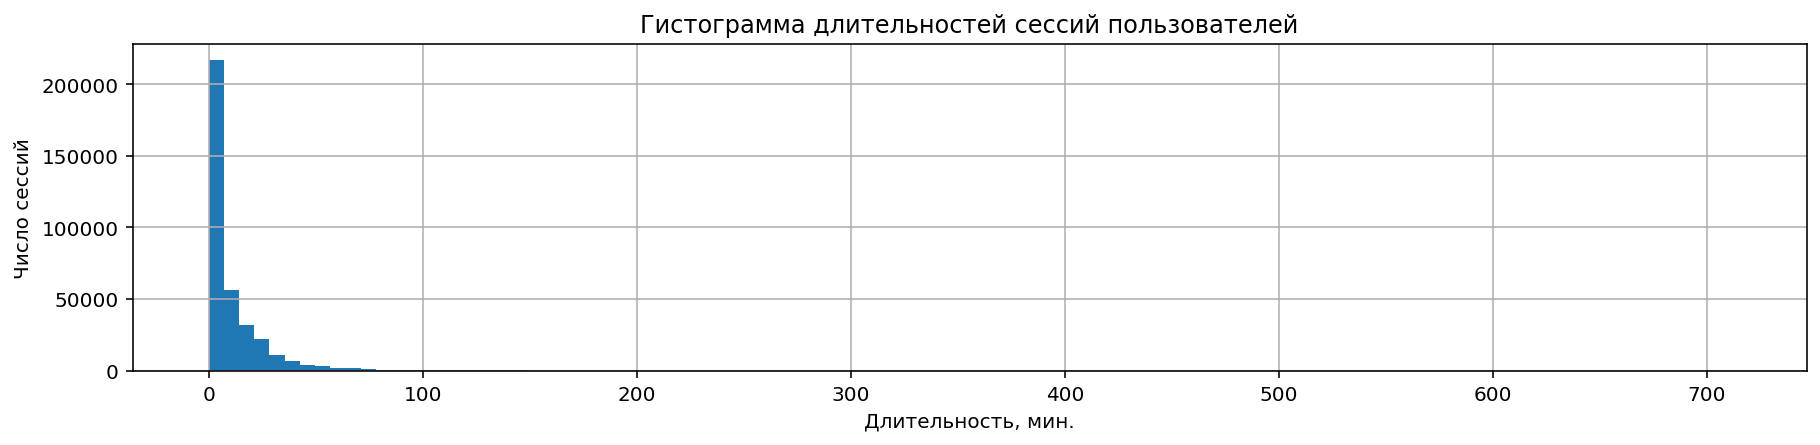

In [35]:
plt.figure(figsize=(15,3));
visits_log['session_duration'].hist(bins=100);
plt.title('Гистограмма длительностей сессий пользователей');
plt.xlabel('Длительность, мин.');
plt.ylabel('Число сессий');

In [36]:
visits_log['session_duration'].describe()

count    359400.000000
mean         10.717529
std          16.618516
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration, dtype: float64

In [37]:
visits_log.groupby('device')['session_duration'].mean()

device
desktop    11.722075
touch       7.993657
Name: session_duration, dtype: float64

In [38]:
visits_log.groupby('device')['session_duration'].median()

device
desktop    6.0
touch      3.0
Name: session_duration, dtype: float64

In [39]:
visits_log['session_duration'].mode()

0    1.0
dtype: float64

Большинство сессий очень короткие, но есть и длинные.
**Наибольшее число сессий с длительностью 1 минута.** По используемым устройствам картина различается:
- Для **настольных систем в среднем длительность 12 минут, по медиане 6 минут**.
- Для **мобильных систем в среднем длительность 8 минут, по медиане 3 минут**.

Для сессий со смартфонов характерны быстрые сессии.

Проверим, сколько есть нулевых сессий.

In [40]:
len(visits_log[visits_log['session_duration'] == 0]) /len(visits_log)

0.0995937673900946

10% данных занимают очень короткие сессии, скорее всего вызванные техническими ошибками при подключении. Для анализа потребуются данные по "настоящим" сессиям не меньше 1 минуты.

In [41]:
sessions = visits_log[visits_log['session_duration'] != 0].reset_index()

In [42]:
sessions

index   device              end_ts  source_id            start_ts  \
0            0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1            1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2            3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
3            5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
4            6  desktop 2018-01-30 12:09:00          1 2018-01-30 11:13:00   
...        ...      ...                 ...        ...                 ...   
323601  359395  desktop 2017-07-29 19:07:19          2 2017-07-29 19:07:00   
323602  359396    touch 2018-01-25 17:38:19          1 2018-01-25 17:38:00   
323603  359397  desktop 2018-03-03 10:12:19          4 2018-03-03 10:12:00   
323604  359398  desktop 2017-11-02 10:12:19          5 2017-11-02 10:12:00   
323605  359399    touch 2017-09-10 13:13:19          2 2017-09-10 13:13:00   

                         uid session_day session_month session_week  \
0       16879256277535980062  2017-12-20    2017-12-01   2017-12-18   
1         104060357244891740  2018-02-19    2018-02-01   2018-02-19   
2       16174680259334210214  2018-05-20    2018-05-01   2018-05-14   
3       16007536194108375387  2017-09-03    2017-09-01   2017-08-28   
4        6661610529277171451  2018-01-30    2018-01-01   2018-01-29   
...                      ...         ...           ...          ...   
323601  18363291481961487539  2017-07-29    2017-07-01   2017-07-24   
323602  18370831553019119586  2018-01-25    2018-01-01   2018-01-22   
323603  18387297585500748294  2018-03-03    2018-03-01   2018-02-26   
323604  18388616944624776485  2017-11-02    2017-11-01   2017-10-30   
323605  18396128934054549559  2017-09-10    2017-09-01   2017-09-04   

        session_duration  
0              18.000000  
1              28.000000  
2              24.000000  
3               1.000000  
4              56.000000  
...                  ...  
323601          0.316667  
323602          0.316667  
323603          0.316667  
323604          0.316667  
323605          0.316667  

[323606 rows x 10 columns]

In [43]:
sessions['session_duration'].describe()

count    323606.000000
mean         11.902993
std          17.105912
min           0.316667
25%           2.000000
50%           6.000000
75%          15.000000
max         711.000000
Name: session_duration, dtype: float64

### Количество уникальных пользователей
Посчитаем сколько сессий и уникальных пользователей есть в месяц, неделю, день.

Посчитаем итоговые метрики DAU, WAU, MAU по числу уникальных пользователей в день, неделю, месяц.

In [44]:
DAU = sessions.groupby('session_day')['uid'].nunique().mean()

In [45]:
DAU

817.5851648351648

In [46]:
WAU = sessions.groupby('session_week')['uid'].nunique().mean()

In [47]:
WAU

5148.301886792453

In [48]:
MAU = sessions.groupby('session_month')['uid'].nunique().mean()

In [49]:
MAU

20955.75

Посчитаем метрику "липкий фактор" по отношению к недельному и месячному показателям.

In [50]:
sticky_mau = DAU/MAU*100

In [51]:
sticky_wau = DAU/WAU*100

In [52]:
sticky_mau

3.9014836731453886

In [53]:
sticky_wau

15.880676440762198

Вовлеченнность пользователей (sticky factor) по неделе составляет 16%, что совсем немногим лучше 1/7 = 14%, как если бы каждый день были новые ползователи. Такая же ситуация и по месяцу: 3.9% немногим выше 1/30 = 3.3%. Можно заключить, что аудитория портала постоянно сменяется, только очень малая доля пользователей возвращается.

Проверим эти же показатели по платформам.

In [54]:
DAU = sessions.groupby(['device','session_day'])['uid'].nunique().groupby('device').mean().reset_index()
DAU

device         uid
0  desktop  599.752747
1    touch  221.460055

In [55]:
WAU = sessions.groupby(['device','session_week'])['uid'].nunique().groupby('device').mean().reset_index()
WAU

device          uid
0  desktop  3756.773585
1    touch  1433.981132

In [56]:
MAU = sessions.groupby(['device','session_month'])['uid'].nunique().groupby('device').mean().reset_index()
MAU

device           uid
0  desktop  15239.916667
1    touch   5999.166667

In [57]:
DAU.columns = ['device', 'DAU']
WAU.columns = ['device', 'WAU']
MAU.columns = ['device', 'MAU']

In [58]:
au_metrics = DAU.merge(WAU, on='device').merge(MAU, on='device')

In [59]:
au_metrics

device         DAU          WAU           MAU
0  desktop  599.752747  3756.773585  15239.916667
1    touch  221.460055  1433.981132   5999.166667

In [60]:
au_metrics['sticky_WAU'] = 100*au_metrics['DAU']/au_metrics['WAU']

In [61]:
au_metrics['sticky_MAU'] = 100*au_metrics['DAU']/au_metrics['MAU']

In [62]:
au_metrics

device         DAU          WAU           MAU  sticky_WAU  sticky_MAU
0  desktop  599.752747  3756.773585  15239.916667   15.964570    3.935407
1    touch  221.460055  1433.981132   5999.166667   15.443722    3.691514

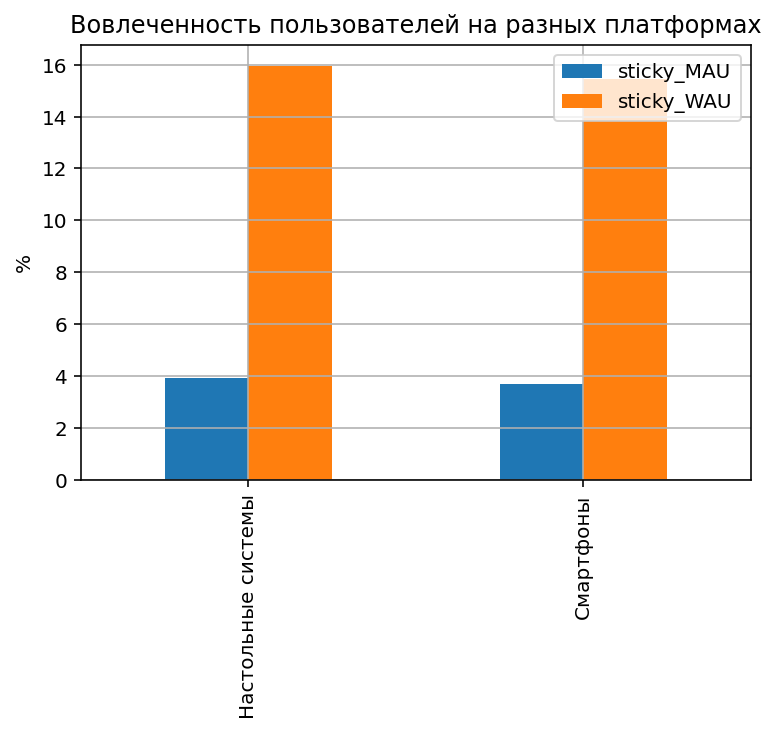

In [63]:
au_metrics[['device','sticky_MAU','sticky_WAU']].plot(kind='bar', grid=True);
plt.title('Вовлеченность пользователей на разных платформах');
plt.ylabel('%');
plt.gca().set_xticklabels(['Настольные системы','Смартфоны']);

Вовлеченнность пользователей по платформам немного отличается, для настольных систем по недельному показателю 16.0%, для мобильных 15.4%. По месячному показателю 3.9% против 3.7% соотвественно. **Вовлеченность пользователей с настольных систем выше, чем с мобильных устройств.** По-видимому, пользователи настольных систем чаще добавляют сайт в закладки или используют автозаполнение в браузере и таким образом чаще возвращаются на уже посещенные сайты.

Расчитаем также **среднее количество сессий в день**.

In [64]:
session_counts = sessions.groupby(['device','session_day'])['uid'].count().groupby('device').mean().reset_index()

In [65]:
session_counts

device         uid
0  desktop  656.258242
1    touch  233.410468

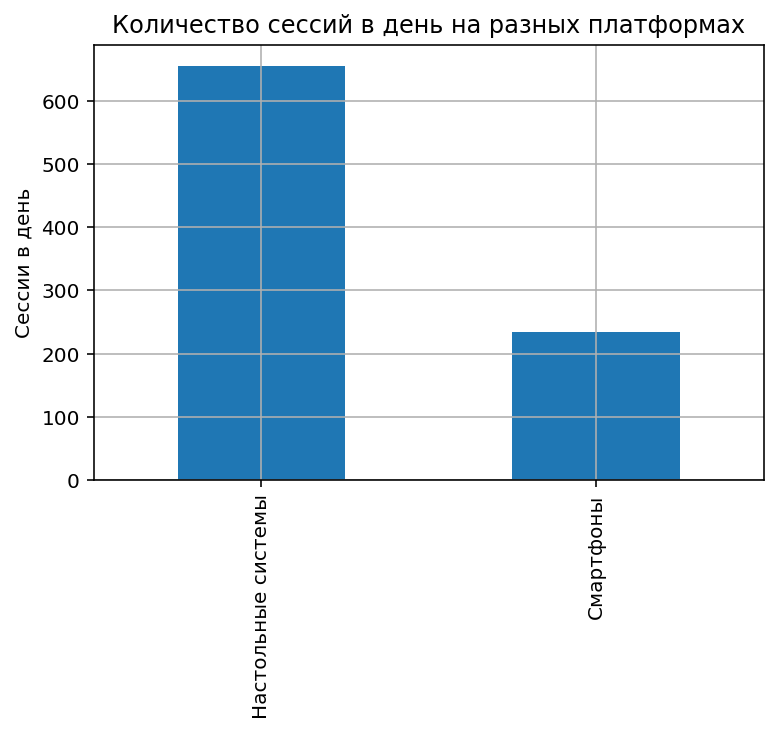

In [66]:
session_counts.plot(kind='bar', grid=True, legend=False);
plt.ylabel('Сессии в день');
plt.title('Количество сессий в день на разных платформах');
plt.gca().set_xticklabels(['Настольные системы','Смартфоны']);

Как количество уникальных пользователей, так и количество сессий в день больше на настольных системах. Вовлеченность пользователей также выше на компьютерах.

### Оценка количества возвращающихся пользователей

Посчитаем Retention Rate (коэффициент удержания) и Churn Rate (коэффициент оттока).

Проведем когортный анализ по времени первого визита, используя данные из таблицы `sessions`.

In [67]:
sessions.head()

index   device              end_ts  source_id            start_ts  \
0      0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1      1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2      3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
3      5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
4      6  desktop 2018-01-30 12:09:00          1 2018-01-30 11:13:00   

                    uid session_day session_month session_week  \
0  16879256277535980062  2017-12-20    2017-12-01   2017-12-18   
1    104060357244891740  2018-02-19    2018-02-01   2018-02-19   
2  16174680259334210214  2018-05-20    2018-05-01   2018-05-14   
3  16007536194108375387  2017-09-03    2017-09-01   2017-08-28   
4   6661610529277171451  2018-01-30    2018-01-01   2018-01-29   

   session_duration  
0              18.0  
1              28.0  
2              24.0  
3               1.0  
4              56.0

Выделим даты первого визита для всех пользователей.

In [68]:
first_visits = sessions.groupby('uid')['session_day'].min()

In [69]:
first_visits

uid
11863502262781         2018-03-01
49537067089222         2018-02-06
297729379853735        2017-06-07
313578113262317        2017-09-18
325320750514679        2017-09-30
                          ...    
18446316582013423015   2018-02-26
18446403737806311543   2017-11-30
18446556406699109058   2018-01-01
18446621818809592527   2017-12-27
18446676030785672386   2017-10-04
Name: session_day, Length: 207051, dtype: datetime64[ns]

In [70]:
first_visits.name = 'first_session_day'

Совместим получившуюся таблицу с изначальной, чтобы создать общий датафрейм.

In [71]:
sessions = sessions.merge(first_visits,on='uid')

In [72]:
sessions['first_session_day'].describe(datetime_is_numeric=True)

count                           323606
mean     2017-11-18 01:53:20.536454656
min                2017-06-01 00:00:00
25%                2017-09-07 00:00:00
50%                2017-11-21 00:00:00
75%                2018-02-03 00:00:00
max                2018-05-31 00:00:00
Name: first_session_day, dtype: object

В данных собрана информация по визитам за целый год с июня 2017 по июнь 2018, поэтому логично проводить когортный анализ по месяцам первой покупки.

Вычислим отдельно день и месяц первой покупки.

In [73]:
sessions['first_session_day'] = sessions['first_session_day'].astype('datetime64[D]')

In [74]:
sessions['first_session_month'] = sessions['first_session_day'].astype('datetime64[M]')

In [75]:
sessions.head()

index   device              end_ts  source_id            start_ts  \
0       0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1       1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2       3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
3  114820  desktop 2018-03-09 20:33:00          4 2018-03-09 20:05:00   
4       5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   

                    uid session_day session_month session_week  \
0  16879256277535980062  2017-12-20    2017-12-01   2017-12-18   
1    104060357244891740  2018-02-19    2018-02-01   2018-02-19   
2  16174680259334210214  2018-05-20    2018-05-01   2018-05-14   
3  16174680259334210214  2018-03-09    2018-03-01   2018-03-05   
4  16007536194108375387  2017-09-03    2017-09-01   2017-08-28   

   session_duration first_session_day first_session_month  
0              18.0        2017-12-20          2017-12-01  
1              28.0        2018-02-19          2018-02-01  
2              24.0        2018-03-09          2018-03-01  
3              28.0        2018-03-09          2018-03-01  
4               1.0        2017-09-03          2017-09-01

Расчитаем возраст когорты по разнице между месяцем визита и месяцем первого визита.

In [76]:
sessions['cohort_lifetime'] = ((sessions['session_day'] - sessions['first_session_day']) / np.timedelta64(1, 'M')).astype('int')

In [77]:
sessions.head()

index   device              end_ts  source_id            start_ts  \
0       0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1       1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2       3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
3  114820  desktop 2018-03-09 20:33:00          4 2018-03-09 20:05:00   
4       5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   

                    uid session_day session_month session_week  \
0  16879256277535980062  2017-12-20    2017-12-01   2017-12-18   
1    104060357244891740  2018-02-19    2018-02-01   2018-02-19   
2  16174680259334210214  2018-05-20    2018-05-01   2018-05-14   
3  16174680259334210214  2018-03-09    2018-03-01   2018-03-05   
4  16007536194108375387  2017-09-03    2017-09-01   2017-08-28   

   session_duration first_session_day first_session_month  cohort_lifetime  
0              18.0        2017-12-20          2017-12-01                0  
1              28.0        2018-02-19          2018-02-01                0  
2              24.0        2018-03-09          2018-03-01                2  
3              28.0        2018-03-09          2018-03-01                0  
4               1.0        2017-09-03          2017-09-01                0

Расчитаем сколько визитов совершают пользователи в каждой когорте.

In [78]:
cohorts = sessions.groupby(['device','first_session_month','cohort_lifetime'])['uid'].nunique().reset_index()

In [79]:
cohorts = cohorts.rename(columns={'uid':'n_users'})

In [80]:
cohorts

device first_session_month  cohort_lifetime  n_users
0    desktop          2017-06-01                0     8856
1    desktop          2017-06-01                1      556
2    desktop          2017-06-01                2      528
3    desktop          2017-06-01                3      631
4    desktop          2017-06-01                4      638
..       ...                 ...              ...      ...
151    touch          2018-03-01                1      150
152    touch          2018-03-01                2       86
153    touch          2018-04-01                0     4401
154    touch          2018-04-01                1       67
155    touch          2018-05-01                0     4557

[156 rows x 4 columns]

In [81]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['device','first_session_month', 'n_users']]

In [82]:
initial_users_count.columns = ['device','first_session_month', 'cohort_users']

In [83]:
cohorts = cohorts.merge(initial_users_count, on=['device','first_session_month'])

In [84]:
cohorts['retention'] = cohorts['n_users'] / cohorts['cohort_users']

In [85]:
retention = cohorts.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='mean')

In [86]:
retention

cohort_lifetime       0         1         2         3         4         5   \
first_session_month                                                          
2017-06-01           1.0  0.052179  0.050598  0.059982  0.060998  0.062761   
2017-07-01           1.0  0.047120  0.052530  0.052280  0.052655  0.044181   
2017-08-01           1.0  0.056864  0.058334  0.053407  0.039752  0.039636   
2017-09-01           1.0  0.063826  0.060801  0.038685  0.036997  0.036235   
2017-10-01           1.0  0.058966  0.043392  0.035507  0.031964  0.022536   
2017-11-01           1.0  0.050818  0.039495  0.035215  0.025694  0.019568   
2017-12-01           1.0  0.044508  0.033703  0.023469  0.019013  0.008262   
2018-01-01           1.0  0.041337  0.027720  0.020732  0.008611       NaN   
2018-02-01           1.0  0.034391  0.020828  0.009867       NaN       NaN   
2018-03-01           1.0  0.029057  0.014041       NaN       NaN       NaN   
2018-04-01           1.0  0.018055       NaN       NaN       NaN       NaN   
2018-05-01           1.0       NaN       NaN       NaN       NaN       NaN   

cohort_lifetime            6         7         8         9         10  \
first_session_month                                                     
2017-06-01           0.055620  0.050979  0.051543  0.044065  0.037644   
2017-07-01           0.044360  0.041684  0.029010  0.025541  0.017085   
2017-08-01           0.038984  0.028936  0.023571  0.012016       NaN   
2017-09-01           0.027170  0.022777  0.010165       NaN       NaN   
2017-10-01           0.018544  0.009719       NaN       NaN       NaN   
2017-11-01           0.010100       NaN       NaN       NaN       NaN   
2017-12-01                NaN       NaN       NaN       NaN       NaN   
2018-01-01                NaN       NaN       NaN       NaN       NaN   
2018-02-01                NaN       NaN       NaN       NaN       NaN   
2018-03-01                NaN       NaN       NaN       NaN       NaN   
2018-04-01                NaN       NaN       NaN       NaN       NaN   
2018-05-01                NaN       NaN       NaN       NaN       NaN   

cohort_lifetime            11  
first_session_month            
2017-06-01           0.031972  
2017-07-01                NaN  
2017-08-01                NaN  
2017-09-01                NaN  
2017-10-01                NaN  
2017-11-01                NaN  
2017-12-01                NaN  
2018-01-01                NaN  
2018-02-01                NaN  
2018-03-01                NaN  
2018-04-01                NaN  
2018-05-01                NaN

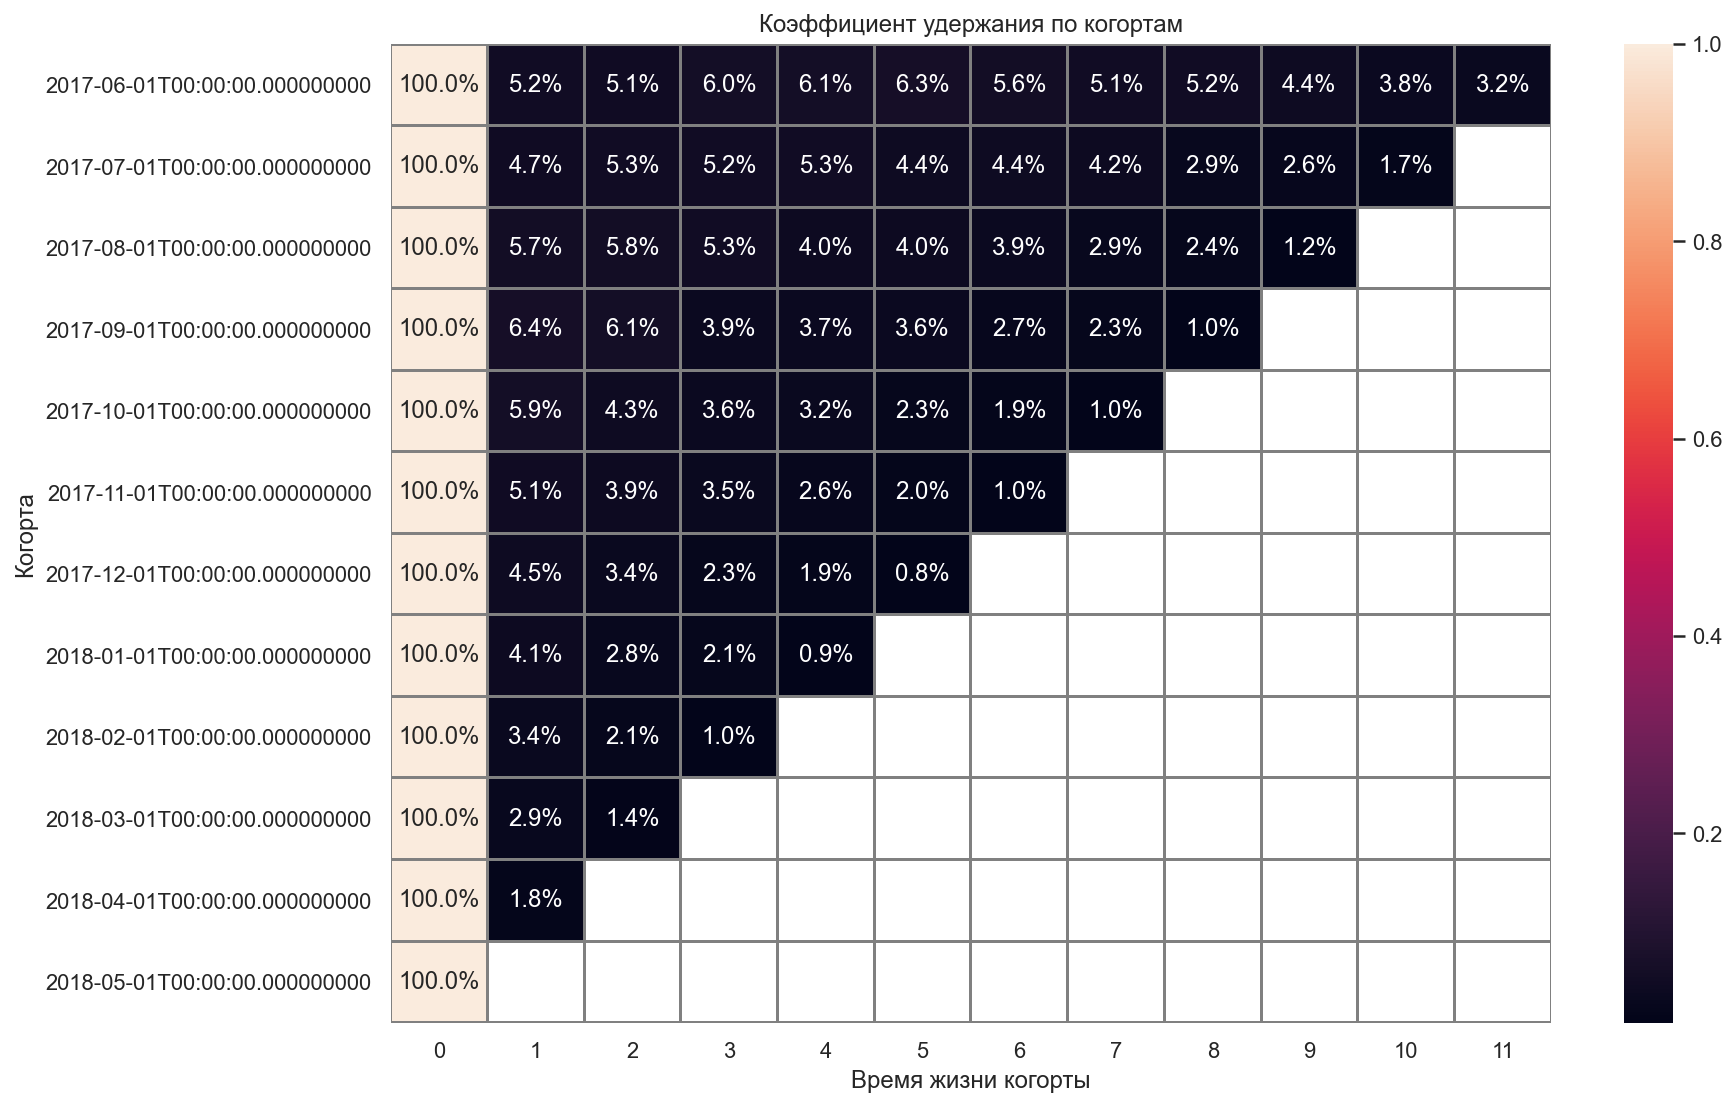

In [87]:
sns.set(style='white');
plt.figure(figsize=(13, 9));
plt.title('Коэффициент удержания по когортам');
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Когорта');

Если исключить первый столбец, различия в следующие периоды будут более явные.

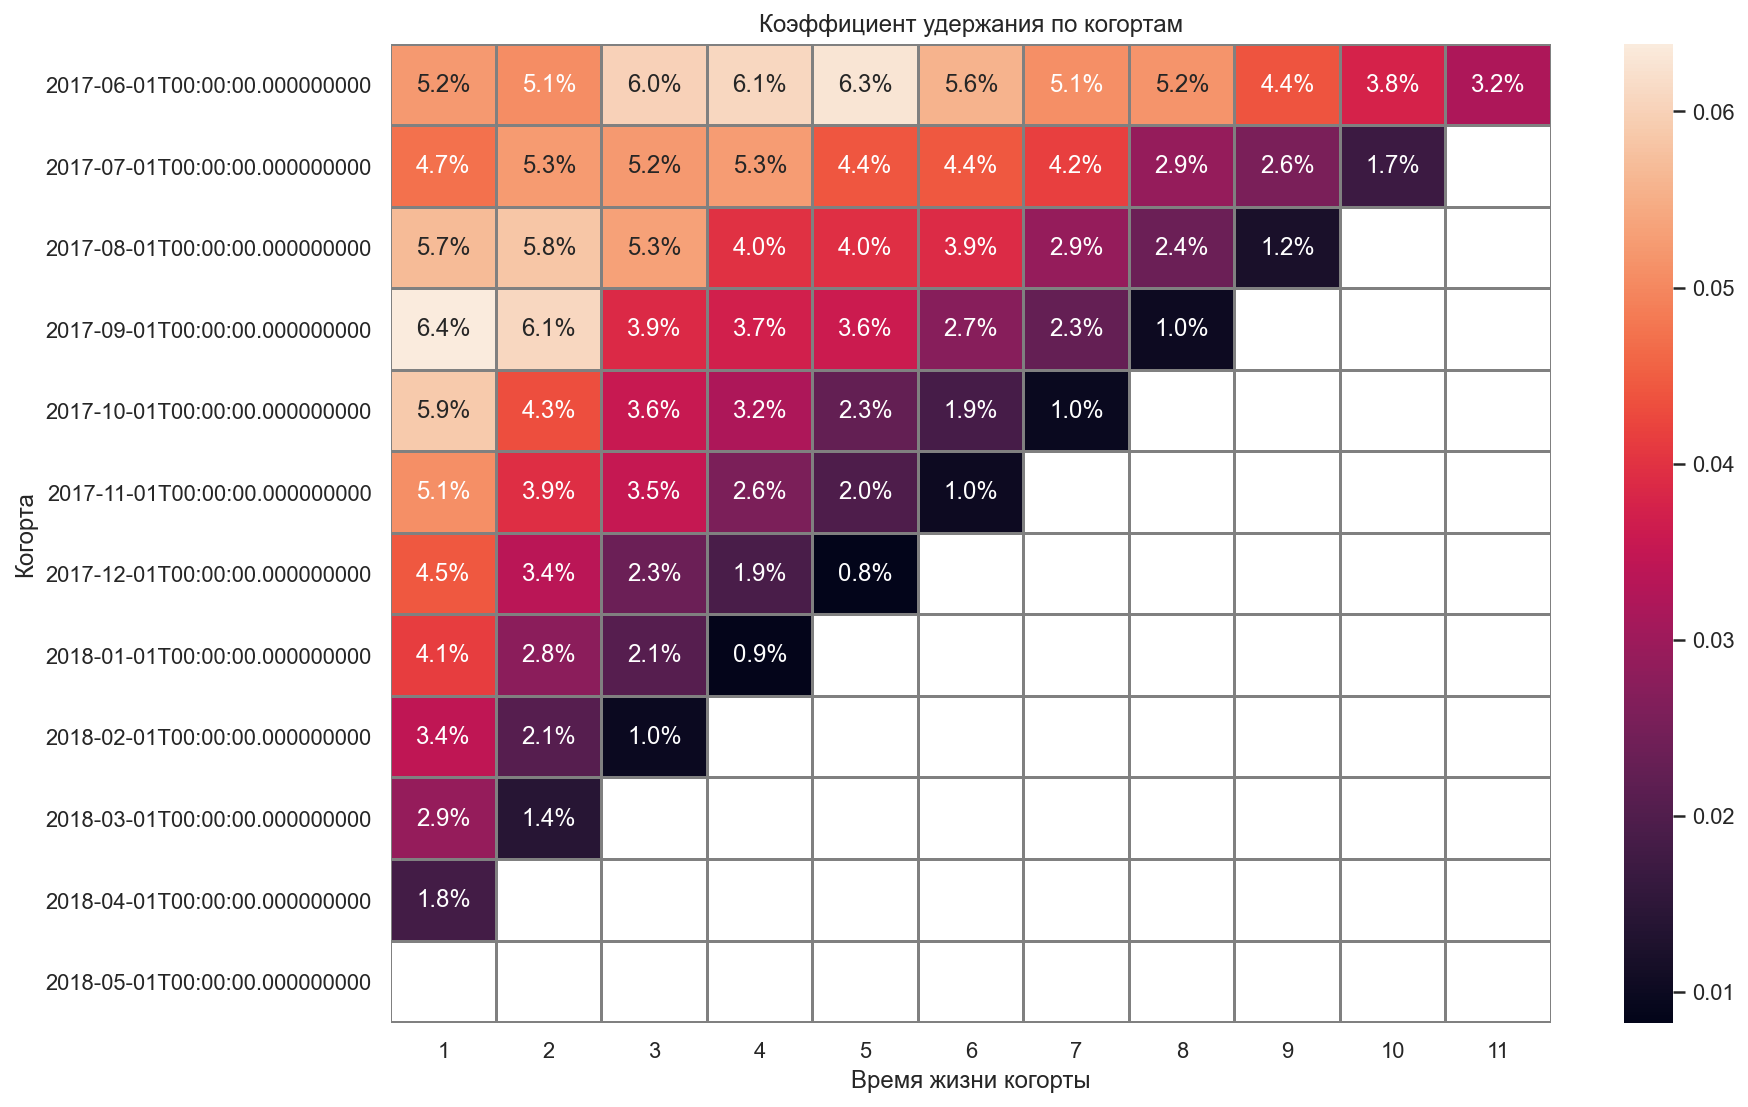

In [88]:
sns.set(style='white');
plt.figure(figsize=(13, 9));
plt.title('Коэффициент удержания по когортам');
sns.heatmap(retention.drop(columns=0, axis=1), annot=True, fmt='.1%', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Когорта');

Как видно, очень мало пользователей возвращаются на портал по всем источникам. Больше всего пользователей осталось из самой первой когорты - 3.2%.

Посмотрим по устройствам.

In [89]:
retention_desktop = cohorts.query('device == "desktop"').pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='mean')

In [90]:
retention_touch = cohorts.query('device == "touch"').pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='mean')

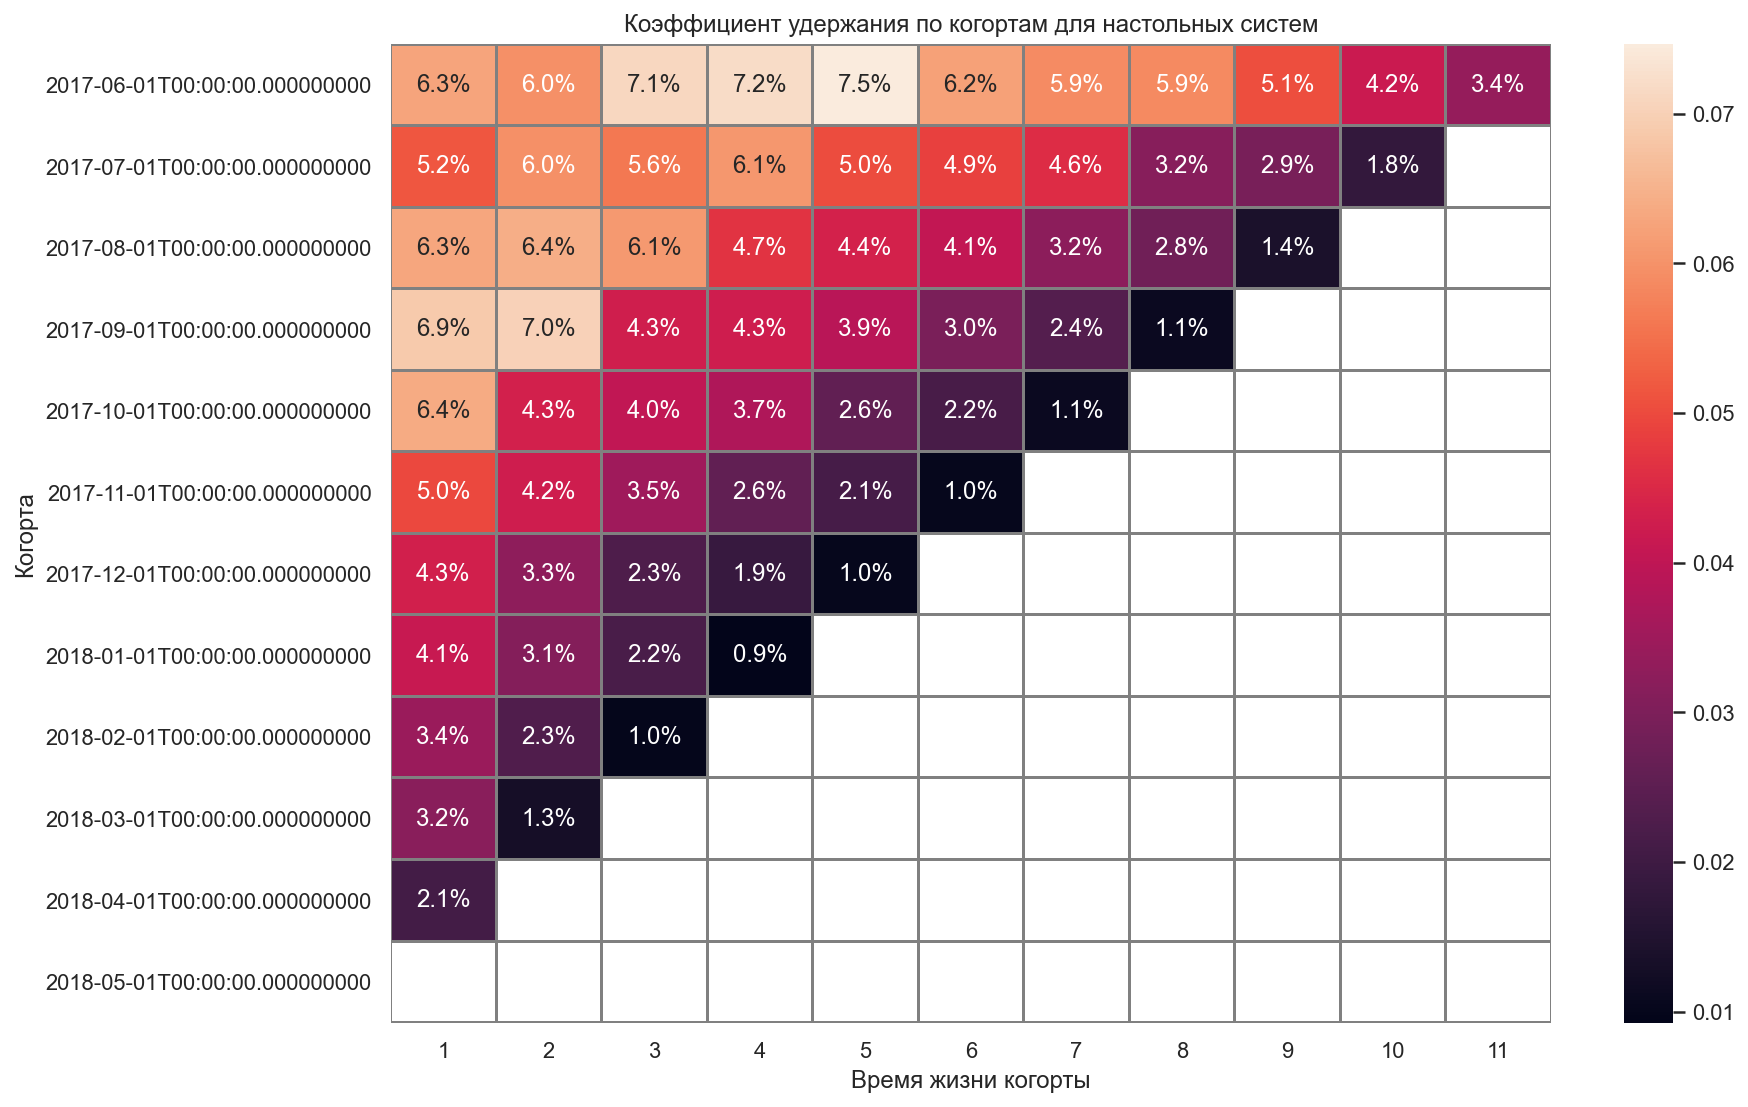

In [91]:
sns.set(style='white');
plt.figure(figsize=(13, 9));
plt.title('Коэффициент удержания по когортам для настольных систем');
sns.heatmap(retention_desktop.drop(columns=0, axis=1), annot=True, fmt='.1%', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Когорта');

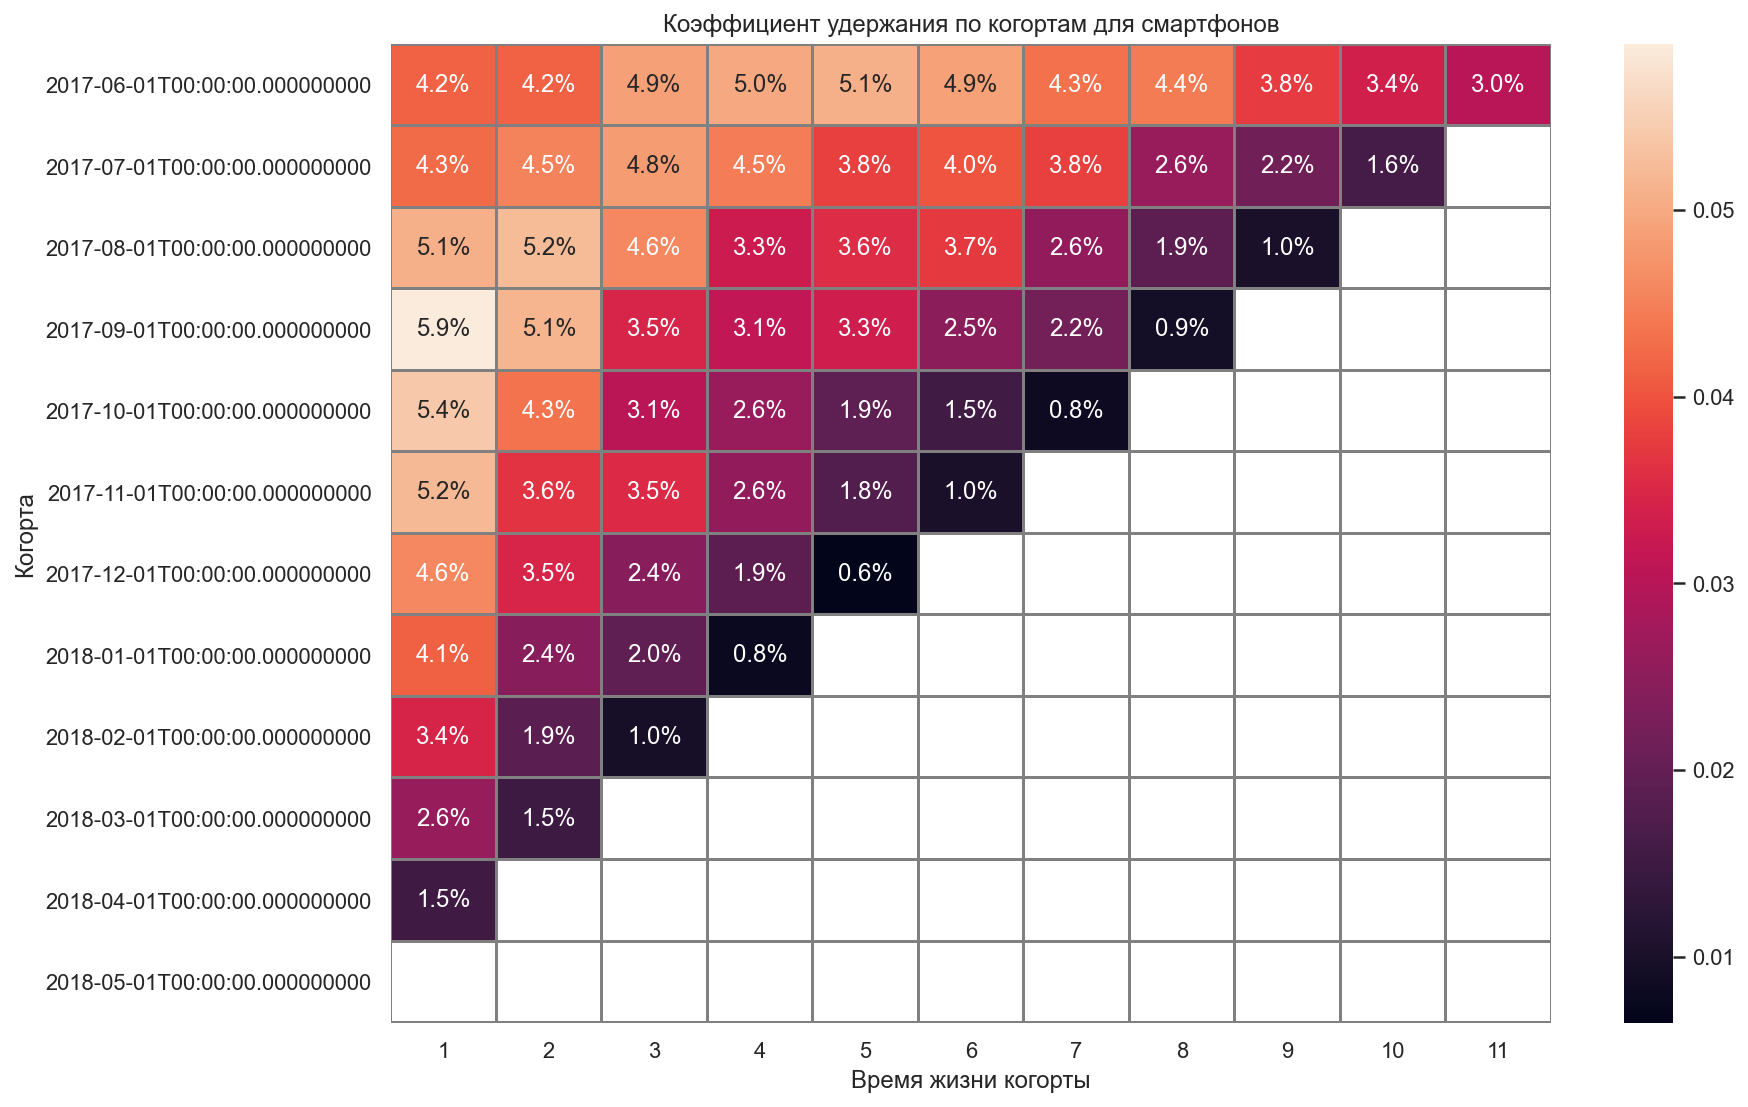

In [92]:
sns.set(style='white');
plt.figure(figsize=(13, 9));
plt.title('Коэффициент удержания по когортам для смартфонов');
sns.heatmap(retention_touch.drop(columns=0, axis=1), annot=True, fmt='.1%', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Когорта');

Как видно, после первого месяца остается на настольных системах всего 6% пользователей, для смартфонов еще меньше - 4%. В сентябре 2019 года для платформ заметно, что осталось больше пользователей во второй месяц (для смартфонов) и второй-третий месяц (для настольных систем). Возможно, это связано с маркетиновыми акциями или другими факторами, которые пришлись на этот период.

Рассчитаем коэффициент оттока клиентов.

In [93]:
cohorts_desktop = cohorts.query('device == "desktop"')
cohorts_touch = cohorts.query('device == "touch"')

In [94]:
cohorts['churn_desktop'] = cohorts_desktop.groupby('first_session_month')['n_users'].pct_change()
cohorts['churn_touch'] = cohorts_touch.groupby('first_session_month')['n_users'].pct_change()

In [95]:
churn_desktop = cohorts.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='churn_desktop',
    aggfunc='mean')
churn_touch = cohorts.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='churn_touch',
    aggfunc='mean')

In [96]:
churn_desktop

cohort_lifetime            1         2         3         4         5   \
first_session_month                                                     
2017-06-01          -0.937218 -0.050360  0.195076  0.011094  0.036050   
2017-07-01          -0.948440  0.159817 -0.061024  0.079665 -0.170874   
2017-08-01          -0.936961  0.020882 -0.052273 -0.235012 -0.065831   
2017-09-01          -0.931223  0.020243 -0.390212 -0.002169 -0.086957   
2017-10-01          -0.936161 -0.320667 -0.068213 -0.073206 -0.309637   
2017-11-01          -0.950352 -0.144095 -0.173418 -0.266462 -0.169102   
2017-12-01          -0.956890 -0.241473 -0.307554 -0.163636 -0.468944   
2018-01-01          -0.958608 -0.247508 -0.295806 -0.576803       NaN   
2018-02-01          -0.965666 -0.334008 -0.562310       NaN       NaN   
2018-03-01          -0.968050 -0.590588       NaN       NaN       NaN   
2018-04-01          -0.979114       NaN       NaN       NaN       NaN   

cohort_lifetime            6         7         8         9         10  \
first_session_month                                                     
2017-06-01          -0.166415 -0.054446 -0.001919 -0.138462 -0.174107   
2017-07-01          -0.032787 -0.062954 -0.304910 -0.074349 -0.381526   
2017-08-01          -0.067114 -0.205036 -0.131222 -0.505208       NaN   
2017-09-01          -0.240476 -0.200627 -0.529412       NaN       NaN   
2017-10-01          -0.160183 -0.485014       NaN       NaN       NaN   
2017-11-01          -0.522613       NaN       NaN       NaN       NaN   
2017-12-01                NaN       NaN       NaN       NaN       NaN   
2018-01-01                NaN       NaN       NaN       NaN       NaN   
2018-02-01                NaN       NaN       NaN       NaN       NaN   
2018-03-01                NaN       NaN       NaN       NaN       NaN   
2018-04-01                NaN       NaN       NaN       NaN       NaN   

cohort_lifetime            11  
first_session_month            
2017-06-01          -0.197297  
2017-07-01                NaN  
2017-08-01                NaN  
2017-09-01                NaN  
2017-10-01                NaN  
2017-11-01                NaN  
2017-12-01                NaN  
2018-01-01                NaN  
2018-02-01                NaN  
2018-03-01                NaN  
2018-04-01                NaN

In [97]:
churn_touch

cohort_lifetime            1         2         3         4         5   \
first_session_month                                                     
2017-06-01          -0.958424  0.000000  0.171642  0.025478  0.018634   
2017-07-01          -0.957319  0.060403  0.069620 -0.076923 -0.147436   
2017-08-01          -0.949311  0.032000 -0.124031 -0.283186  0.086420   
2017-09-01          -0.941125 -0.126394 -0.327660 -0.094937  0.069930   
2017-10-01          -0.945907 -0.197368 -0.295082 -0.134884 -0.274194   
2017-11-01          -0.948011 -0.297994 -0.032653 -0.274262 -0.308140   
2017-12-01          -0.954094 -0.243986 -0.300000 -0.214286 -0.661157   
2018-01-01          -0.958717 -0.411538 -0.196078 -0.593496       NaN   
2018-02-01          -0.965551 -0.454545 -0.482456       NaN       NaN   
2018-03-01          -0.973836 -0.426667       NaN       NaN       NaN   
2018-04-01          -0.984776       NaN       NaN       NaN       NaN   

cohort_lifetime            6         7         8         9         10  \
first_session_month                                                     
2017-06-01          -0.036585 -0.120253  0.028777 -0.153846 -0.107438   
2017-07-01           0.052632 -0.057143 -0.303030 -0.173913 -0.263158   
2017-08-01           0.045455 -0.315217 -0.253968 -0.468085       NaN   
2017-09-01          -0.261438 -0.115044 -0.580000       NaN       NaN   
2017-10-01          -0.200000 -0.462963       NaN       NaN       NaN   
2017-11-01          -0.436975       NaN       NaN       NaN       NaN   
2017-12-01                NaN       NaN       NaN       NaN       NaN   
2018-01-01                NaN       NaN       NaN       NaN       NaN   
2018-02-01                NaN       NaN       NaN       NaN       NaN   
2018-03-01                NaN       NaN       NaN       NaN       NaN   
2018-04-01                NaN       NaN       NaN       NaN       NaN   

cohort_lifetime            11  
first_session_month            
2017-06-01          -0.092593  
2017-07-01                NaN  
2017-08-01                NaN  
2017-09-01                NaN  
2017-10-01                NaN  
2017-11-01                NaN  
2017-12-01                NaN  
2018-01-01                NaN  
2018-02-01                NaN  
2018-03-01                NaN  
2018-04-01                NaN

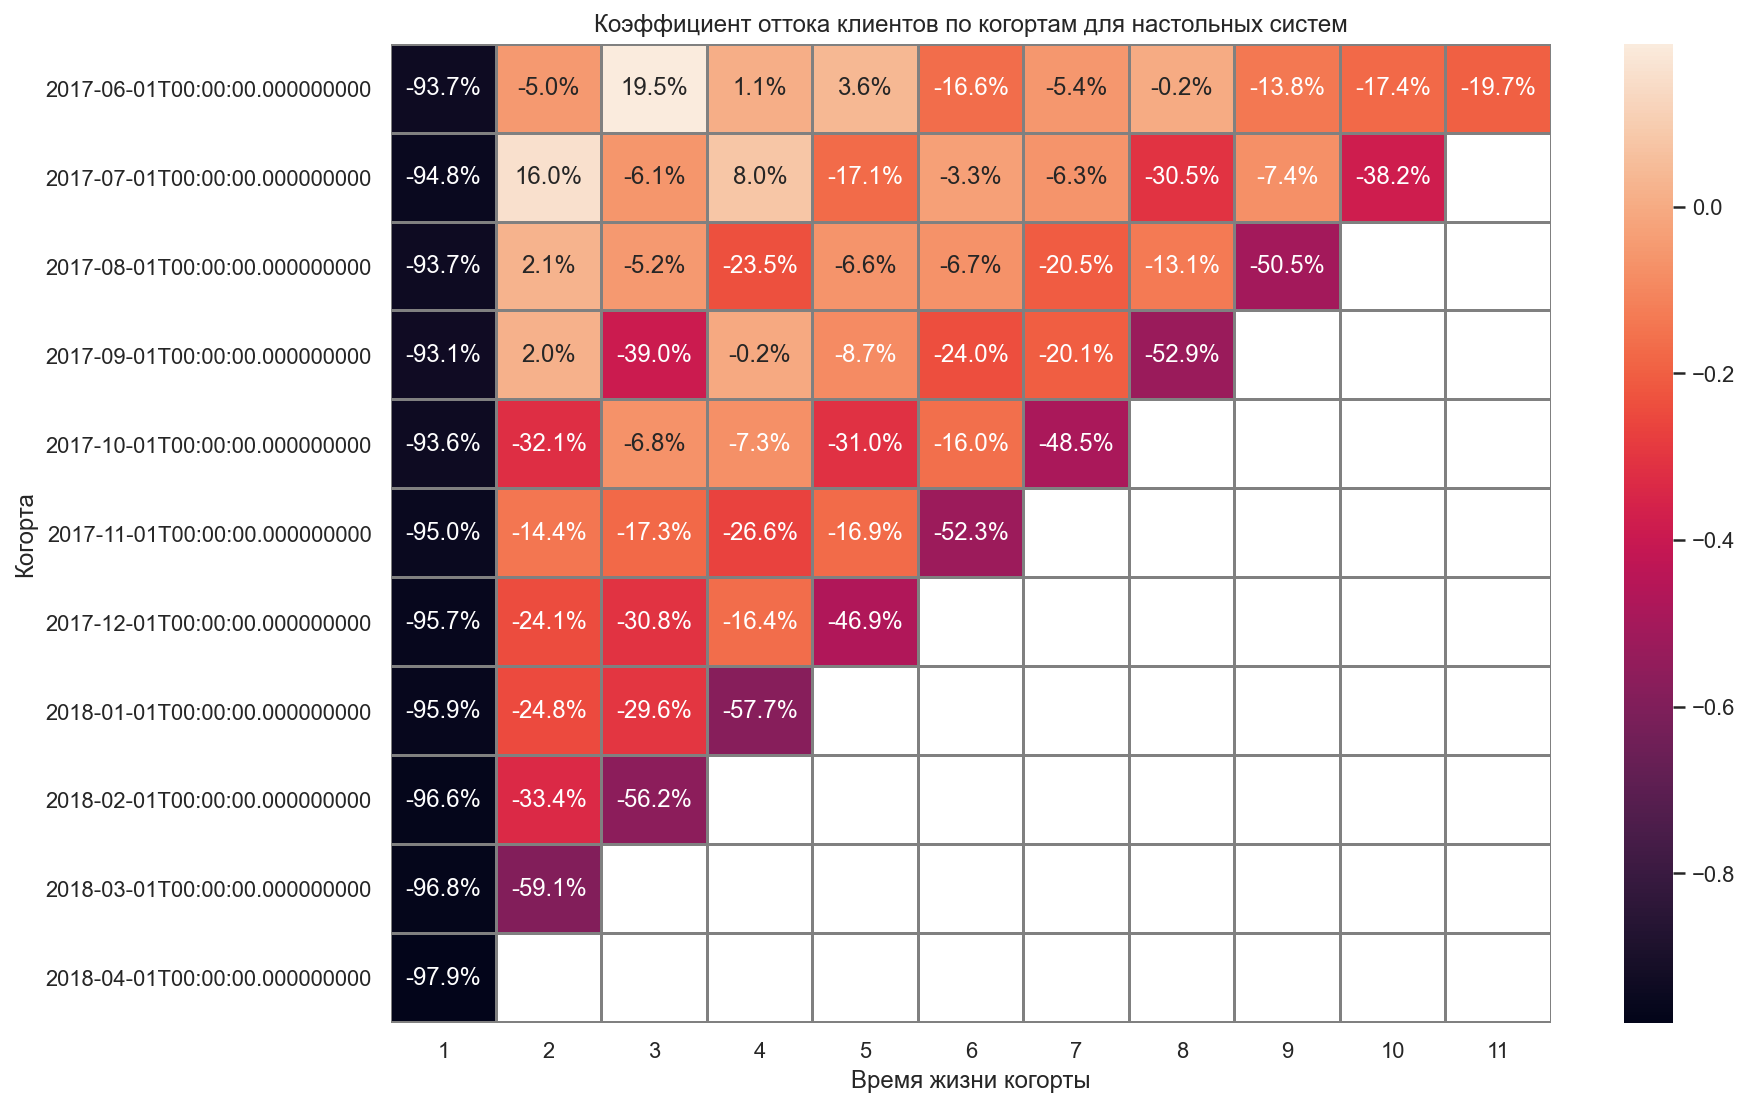

In [98]:
sns.set(style='white');
plt.figure(figsize=(13, 9));
plt.title('Коэффициент оттока клиентов по когортам для настольных систем');
sns.heatmap(churn_desktop, annot=True, fmt='.1%', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Когорта');

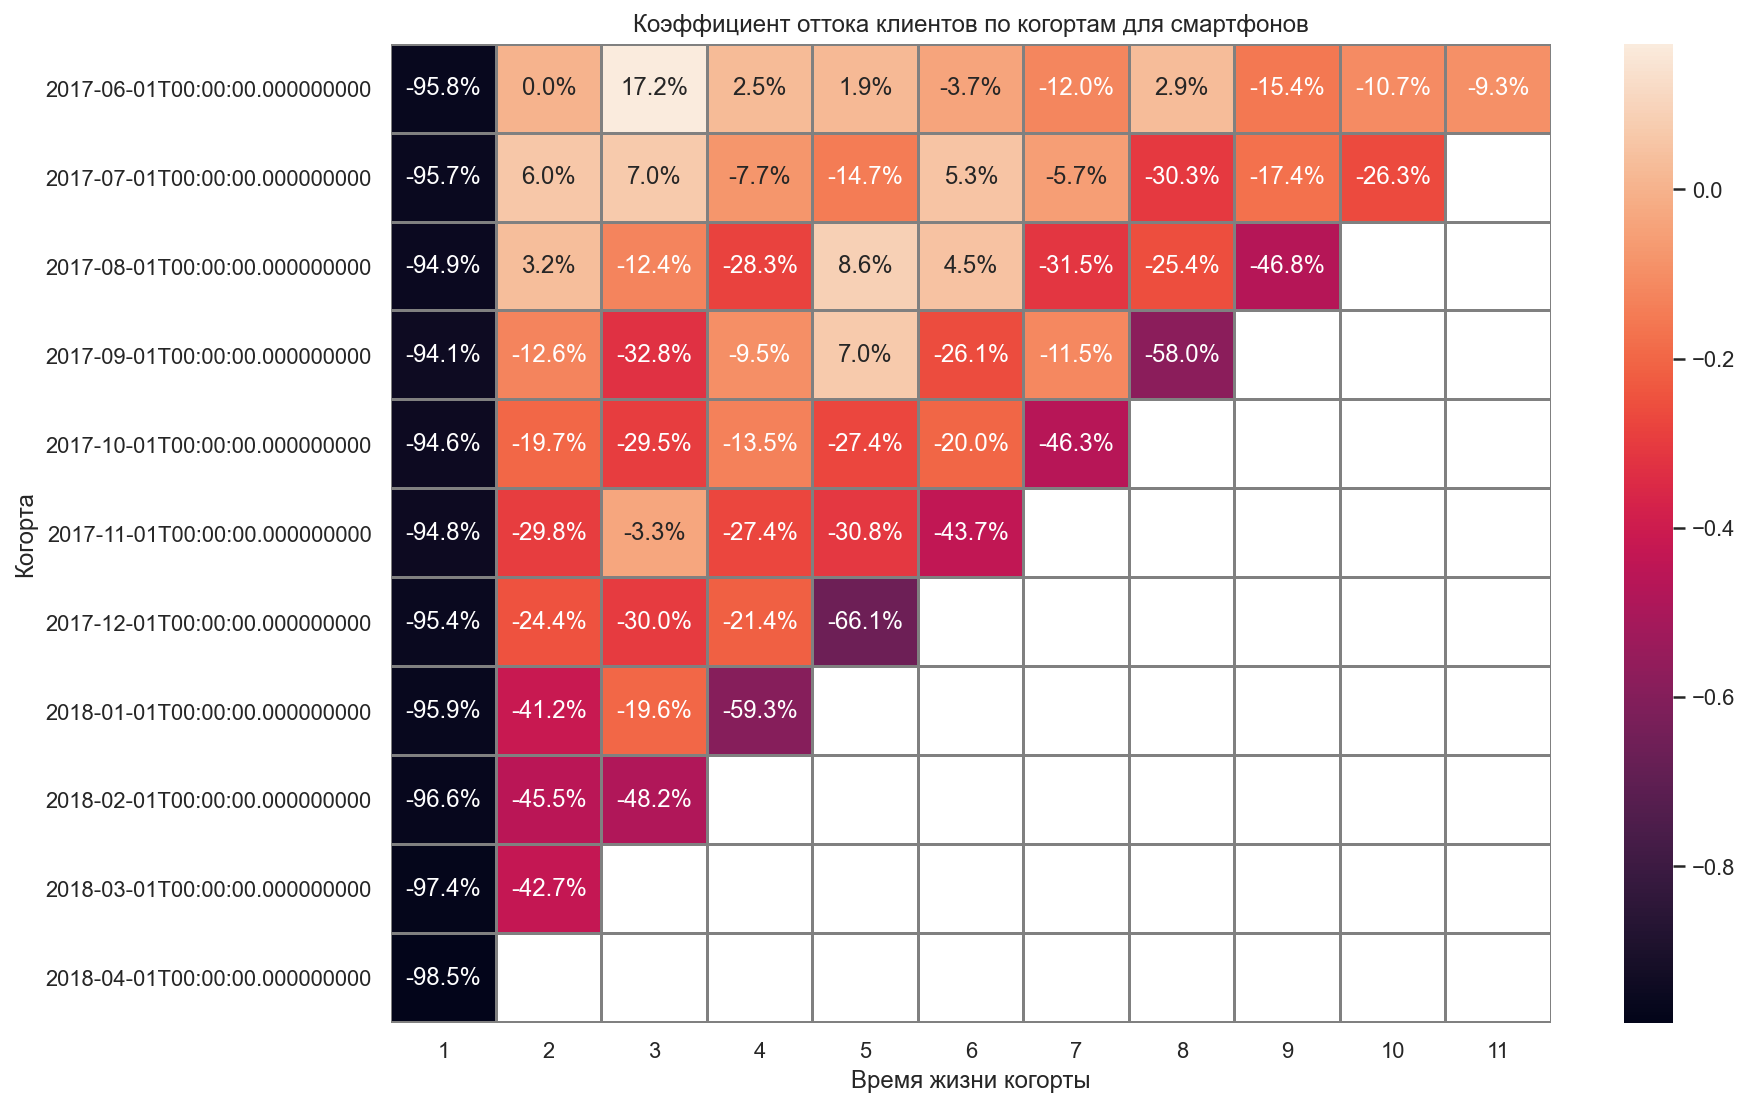

In [99]:
sns.set(style='white');
plt.figure(figsize=(13, 9));
plt.title('Коэффициент оттока клиентов по когортам для смартфонов');
sns.heatmap(churn_touch, annot=True, fmt='.1%', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Когорта');

Расчеты метрик оттока клиентов показывают, что после первого месяца на обеих платформах остается всего около 5-7% пользователей, а их число потом также спадает. В последнем периоде отток клиентов наибольший (от 40% до 60%). Для первой когорты характерен рост числа пользователей на третий месяц в размере 17%-19%, что соответствует сентябрю 2017 года, где мы ранее отмечали меньший отток клиентов. Возможно, маркетинговые акции не только способствовали удержанию новых клиентов, но и вернули тех, кто ранее уже пользовался продуктом. Также можно отметить, что более новые когорты показывают даже больший отток, чем более старые, для них наблюдается сильный отток уже со второго-третьего месяца. Для последней когорты в анализе отток пользователей уже на второй месяц составил внушительные 98% для всех платформ, что сильно хуже первой когорты с показателем 94%-95%.

#### Расчет метрик продаж
*   Когда люди начинают покупать?
*   Сколько раз покупают за период?
*   Какой средний чек?
*   Сколько денег приносят? (LTV)

Для ответа на вопрос "Когда люди начинают покупать?" выделим из таблицы с сесииями для каждого пользователя дату визита, а затем совметим ее с таблицей заказов по `uid`.

In [100]:
sessions.head()

index   device              end_ts  source_id            start_ts  \
0       0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1       1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2       3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
3  114820  desktop 2018-03-09 20:33:00          4 2018-03-09 20:05:00   
4       5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   

                    uid session_day session_month session_week  \
0  16879256277535980062  2017-12-20    2017-12-01   2017-12-18   
1    104060357244891740  2018-02-19    2018-02-01   2018-02-19   
2  16174680259334210214  2018-05-20    2018-05-01   2018-05-14   
3  16174680259334210214  2018-03-09    2018-03-01   2018-03-05   
4  16007536194108375387  2017-09-03    2017-09-01   2017-08-28   

   session_duration first_session_day first_session_month  cohort_lifetime  
0              18.0        2017-12-20          2017-12-01                0  
1              28.0        2018-02-19          2018-02-01                0  
2              24.0        2018-03-09          2018-03-01                2  
3              28.0        2018-03-09          2018-03-01                0  
4               1.0        2017-09-03          2017-09-01                0

In [101]:
sessions_users = sessions[['uid', 'device', 'source_id','session_day']]

In [102]:
sessions_users.head()

uid   device  source_id session_day
0  16879256277535980062    touch          4  2017-12-20
1    104060357244891740  desktop          2  2018-02-19
2  16174680259334210214  desktop          9  2018-05-20
3  16174680259334210214  desktop          4  2018-03-09
4  16007536194108375387  desktop          5  2017-09-03

In [103]:
orders_log.head()

buy_ts  revenue                   uid
0 2017-06-01 00:10:00    17.00  10329302124590727494
1 2017-06-01 00:25:00     0.55  11627257723692907447
2 2017-06-01 00:27:00     0.37  17903680561304213844
3 2017-06-01 00:29:00     0.55  16109239769442553005
4 2017-06-01 07:58:00     0.37  14200605875248379450

In [104]:
orders_users = orders_log[['uid','buy_ts']]

In [105]:
orders_users['order_date'] = orders_users['buy_ts'].astype('datetime64[D]')

In [106]:
orders_users.head()

uid              buy_ts order_date
0  10329302124590727494 2017-06-01 00:10:00 2017-06-01
1  11627257723692907447 2017-06-01 00:25:00 2017-06-01
2  17903680561304213844 2017-06-01 00:27:00 2017-06-01
3  16109239769442553005 2017-06-01 00:29:00 2017-06-01
4  14200605875248379450 2017-06-01 07:58:00 2017-06-01

Совместим таблицу визитов с заказами по пользователям, исходя из предположения, что заказ сопровождается визитом и их даты совпадают. Таким образом мы сможем получить данные с какого устройства и из какого источника пришел пользователь в первый раз и когда совершил покупку.

In [107]:
users_report = sessions_users.merge(orders_users, left_on=['uid','session_day'], right_on=['uid','order_date'], how='left')

Колонка с временем заказа не нужна.

In [108]:
users_report = users_report.drop(columns=['buy_ts'])

In [109]:
users_report.head()

uid   device  source_id session_day order_date
0  16879256277535980062    touch          4  2017-12-20        NaT
1    104060357244891740  desktop          2  2018-02-19        NaT
2  16174680259334210214  desktop          9  2018-05-20        NaT
3  16174680259334210214  desktop          4  2018-03-09 2018-03-09
4  16007536194108375387  desktop          5  2017-09-03        NaT

Теперь в одной таблице собрана информация о том, когда были визиты и был ли заказ при этом визите.

Проверим на конкретном пользователе.

In [110]:
users_report[users_report['uid'] == 5081614443770358]

uid   device  source_id session_day order_date
208447  5081614443770358  desktop          3  2017-11-13 2017-11-13
208448  5081614443770358  desktop          3  2017-10-20        NaT
208449  5081614443770358  desktop          5  2017-11-13 2017-11-13
208450  5081614443770358  desktop          4  2018-02-26        NaT
208451  5081614443770358  desktop          9  2018-01-08        NaT

Так как нельзя понять по предоставленным данным, откуда пришел пользователь, если он в течение дня заходил из 2 источников (3 и 5), в таблице заказ был отмечен для каждого источника.

Теперь сгруппируем данные по пользователю, устройству и источнику по времени первого заказа и первой покупке.

In [111]:
users_report_pivot = users_report.groupby(['uid','device','source_id'])[['session_day','order_date']].agg({'session_day':'min', 'order_date':'min'})

In [112]:
users_report_pivot = users_report_pivot.reset_index()

In [113]:
users_report_pivot.head()

uid   device  source_id session_day order_date
0   11863502262781    touch          3  2018-03-01        NaT
1   49537067089222    touch          2  2018-02-06        NaT
2  297729379853735  desktop          3  2017-06-07        NaT
3  313578113262317  desktop          2  2017-09-18        NaT
4  325320750514679  desktop          5  2017-09-30        NaT

In [114]:
users_report_pivot[users_report_pivot['uid'] == 5081614443770358]

uid   device  source_id session_day order_date
69  5081614443770358  desktop          3  2017-10-20 2017-11-13
70  5081614443770358  desktop          4  2018-02-26        NaT
71  5081614443770358  desktop          5  2017-11-13 2017-11-13
72  5081614443770358  desktop          9  2018-01-08        NaT

Таким образом в получившейся сводной таблице для каждого источника и устройства есть данные о первом заказе и первом визите. Расчитаем задержку между визитом и заказом.

In [115]:
users_report_pivot['buy_delay'] = (users_report_pivot['order_date'] - users_report_pivot['session_day']) / np.timedelta64(1, 'D')

In [116]:
users_report_pivot.head()

uid   device  source_id session_day order_date  buy_delay
0   11863502262781    touch          3  2018-03-01        NaT        NaN
1   49537067089222    touch          2  2018-02-06        NaT        NaN
2  297729379853735  desktop          3  2017-06-07        NaT        NaN
3  313578113262317  desktop          2  2017-09-18        NaT        NaN
4  325320750514679  desktop          5  2017-09-30        NaT        NaN

In [117]:
users_report_pivot['buy_delay'].describe()

count    37662.000000
mean         4.891270
std         25.963936
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        357.000000
Name: buy_delay, dtype: float64

Как видно по данным, подавляющее большинство заказов совершается в день первого визита, посмотроим еще одну сводную таблицу, чтобы узнать как это различается для разных источников трафика.

In [118]:
users_report_pivot.pivot_table(index='source_id', columns='device', values='buy_delay', aggfunc=['count','max','mean','median','min'], dropna=False)

count           max              mean             median        \
device    desktop touch desktop  touch    desktop      touch desktop touch   
source_id                                                                    
1            4035  1104   347.0  308.0   3.756382   3.884964     0.0   0.0   
2            3523  1027   345.0  270.0   9.451036   6.306719     0.0   0.0   
3            7602  1317   336.0  240.0   4.399369   1.950645     0.0   0.0   
4            7625  1978   352.0  343.0   5.272525   5.068251     0.0   0.0   
5            6179  1073   344.0  176.0   2.830393   1.744641     0.0   0.0   
6               0     0     NaN    NaN        NaN        NaN     NaN   NaN   
7               1     0     0.0    NaN   0.000000        NaN     0.0   NaN   
9             797   153   294.0  251.0  18.324969  10.581699     0.0   0.0   
10           1002   246   357.0  182.0   2.729541   1.768293     0.0   0.0   

              min        
device    desktop touch  
source_id                
1             0.0   0.0  
2             0.0   0.0  
3             0.0   0.0  
4             0.0   0.0  
5             0.0   0.0  
6             NaN   NaN  
7             0.0   NaN  
9             0.0   0.0  
10            0.0   0.0

In [119]:
len(users_report_pivot[users_report_pivot['buy_delay'] == 0]) / len(users_report_pivot.dropna())

0.9065370930911795

В 90% случаев заказ происходит в тот же день. По сводной таблице выше видно, что по 6 источнику не было совершено ни одного заказа, а по 7 источнику заказ был, но только с настольной платформы. Несмотря на то, что большинство заказов по медиане совершались в тот же день, по среднему можно сделать вывод, что быстрее всего с настольных систем в среднем совершали заказ на 2-3 день пользователи из источника 5, далее источники 1, 10, 3, 4 и 2. В среднем заказс мобильных устройств совершался на 2-3 день для всех источников. Также видно, что покупки по времени для источника 1 практически равны для настольных и мобильных систем, поэтому источник 1 можно считать универсальным по платформам.

---

Проведем когортный анализ по времени первой покупки, используя данные из таблицы `orders_log`.

In [120]:
orders_log.head()

buy_ts  revenue                   uid
0 2017-06-01 00:10:00    17.00  10329302124590727494
1 2017-06-01 00:25:00     0.55  11627257723692907447
2 2017-06-01 00:27:00     0.37  17903680561304213844
3 2017-06-01 00:29:00     0.55  16109239769442553005
4 2017-06-01 07:58:00     0.37  14200605875248379450

Выделим даты первой покупки для всех пользователей.

In [121]:
first_orders = orders_log.groupby('uid')['buy_ts'].min()

In [122]:
first_orders

uid
313578113262317        2018-01-03 21:51:00
1575281904278712       2017-06-03 10:13:00
2429014661409475       2017-10-11 18:33:00
2464366381792757       2018-01-28 15:54:00
2551852515556206       2017-11-24 10:14:00
                               ...        
18445147675727495770   2017-11-24 09:03:00
18445407535914413204   2017-09-22 23:55:00
18445601152732270159   2018-03-26 22:54:00
18446156210226471712   2018-02-18 19:34:00
18446167067214817906   2017-10-17 10:16:00
Name: buy_ts, Length: 36523, dtype: datetime64[ns]

In [123]:
first_orders.name = 'first_order_day'

Совместим получившуюся таблицу с изначальной, чтобы создать общий датафрейм.

In [124]:
orders_activity = orders_log.merge(first_orders,on='uid')

In [125]:
orders_activity['first_order_day'].describe(datetime_is_numeric=True)

count                            50415
mean     2017-11-30 19:10:17.995834368
min                2017-06-01 00:10:00
25%                2017-09-26 17:18:30
50%                2017-11-30 14:09:00
75%                2018-02-14 16:43:30
max                2018-06-01 00:02:00
Name: first_order_day, dtype: object

В данных собрана информация по заказам за целый год с июня 2017 по июнь 2018, поэтому логично проводить когортный анализ по месяцам первой покупки.

Вычислим отдельно день и месяц первой покупки.

In [126]:
orders_activity['first_order_day'] = orders_activity['first_order_day'].astype('datetime64[D]')

In [127]:
orders_activity['first_order_month'] = orders_activity['first_order_day'].astype('datetime64[M]')

In [128]:
orders_activity

buy_ts  revenue                   uid first_order_day  \
0     2017-06-01 00:10:00    17.00  10329302124590727494      2017-06-01   
1     2017-06-01 00:25:00     0.55  11627257723692907447      2017-06-01   
2     2017-06-01 00:27:00     0.37  17903680561304213844      2017-06-01   
3     2017-06-01 00:29:00     0.55  16109239769442553005      2017-06-01   
4     2017-06-01 07:58:00     0.37  14200605875248379450      2017-06-01   
...                   ...      ...                   ...             ...   
50410 2018-05-31 23:50:00     4.64  12296626599487328624      2018-05-31   
50411 2018-05-31 23:50:00     5.80  11369640365507475976      2018-05-31   
50412 2018-05-31 23:54:00     0.30   1786462140797698849      2018-05-31   
50413 2018-05-31 23:56:00     3.67   3993697860786194247      2018-05-31   
50414 2018-06-01 00:02:00     3.42     83872787173869366      2018-06-01   

      first_order_month  
0            2017-06-01  
1            2017-06-01  
2            2017-06-01  
3            2017-06-01  
4            2017-06-01  
...                 ...  
50410        2018-05-01  
50411        2018-05-01  
50412        2018-05-01  
50413        2018-05-01  
50414        2018-06-01  

[50415 rows x 5 columns]

Расчитаем время возраст когорты по разнице между месяцем заказа и месяцем первого заказа.

In [129]:
orders_activity['cohort_lifetime'] = ((orders_activity['buy_ts'] - orders_activity['first_order_day']) / np.timedelta64(1, 'M')).astype('int')

In [130]:
orders_activity.head()

buy_ts  revenue                   uid first_order_day  \
0 2017-06-01 00:10:00    17.00  10329302124590727494      2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447      2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844      2017-06-01   
3 2017-06-01 00:29:00     0.55  16109239769442553005      2017-06-01   
4 2017-06-01 07:58:00     0.37  14200605875248379450      2017-06-01   

  first_order_month  cohort_lifetime  
0        2017-06-01                0  
1        2017-06-01                0  
2        2017-06-01                0  
3        2017-06-01                0  
4        2017-06-01                0

Расчитаем сколько покупок совершают пользователи по месяцам с помощью когортного анализа.

In [131]:
cohorts = orders_activity.groupby(['first_order_month','cohort_lifetime'])['uid'].count().reset_index()

In [132]:
cohorts.rename(columns={'uid':'orders_num'}, inplace=True)

In [133]:
cohorts

first_order_month  cohort_lifetime  orders_num
0         2017-06-01                0        2414
1         2017-06-01                1         157
2         2017-06-01                2         167
3         2017-06-01                3         275
4         2017-06-01                4         265
..               ...              ...         ...
74        2018-03-01                2          84
75        2018-04-01                0        2608
76        2018-04-01                1          82
77        2018-05-01                0        3249
78        2018-06-01                0           1

[79 rows x 3 columns]

In [134]:
orders_pivot = cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='orders_num',
    aggfunc='sum')

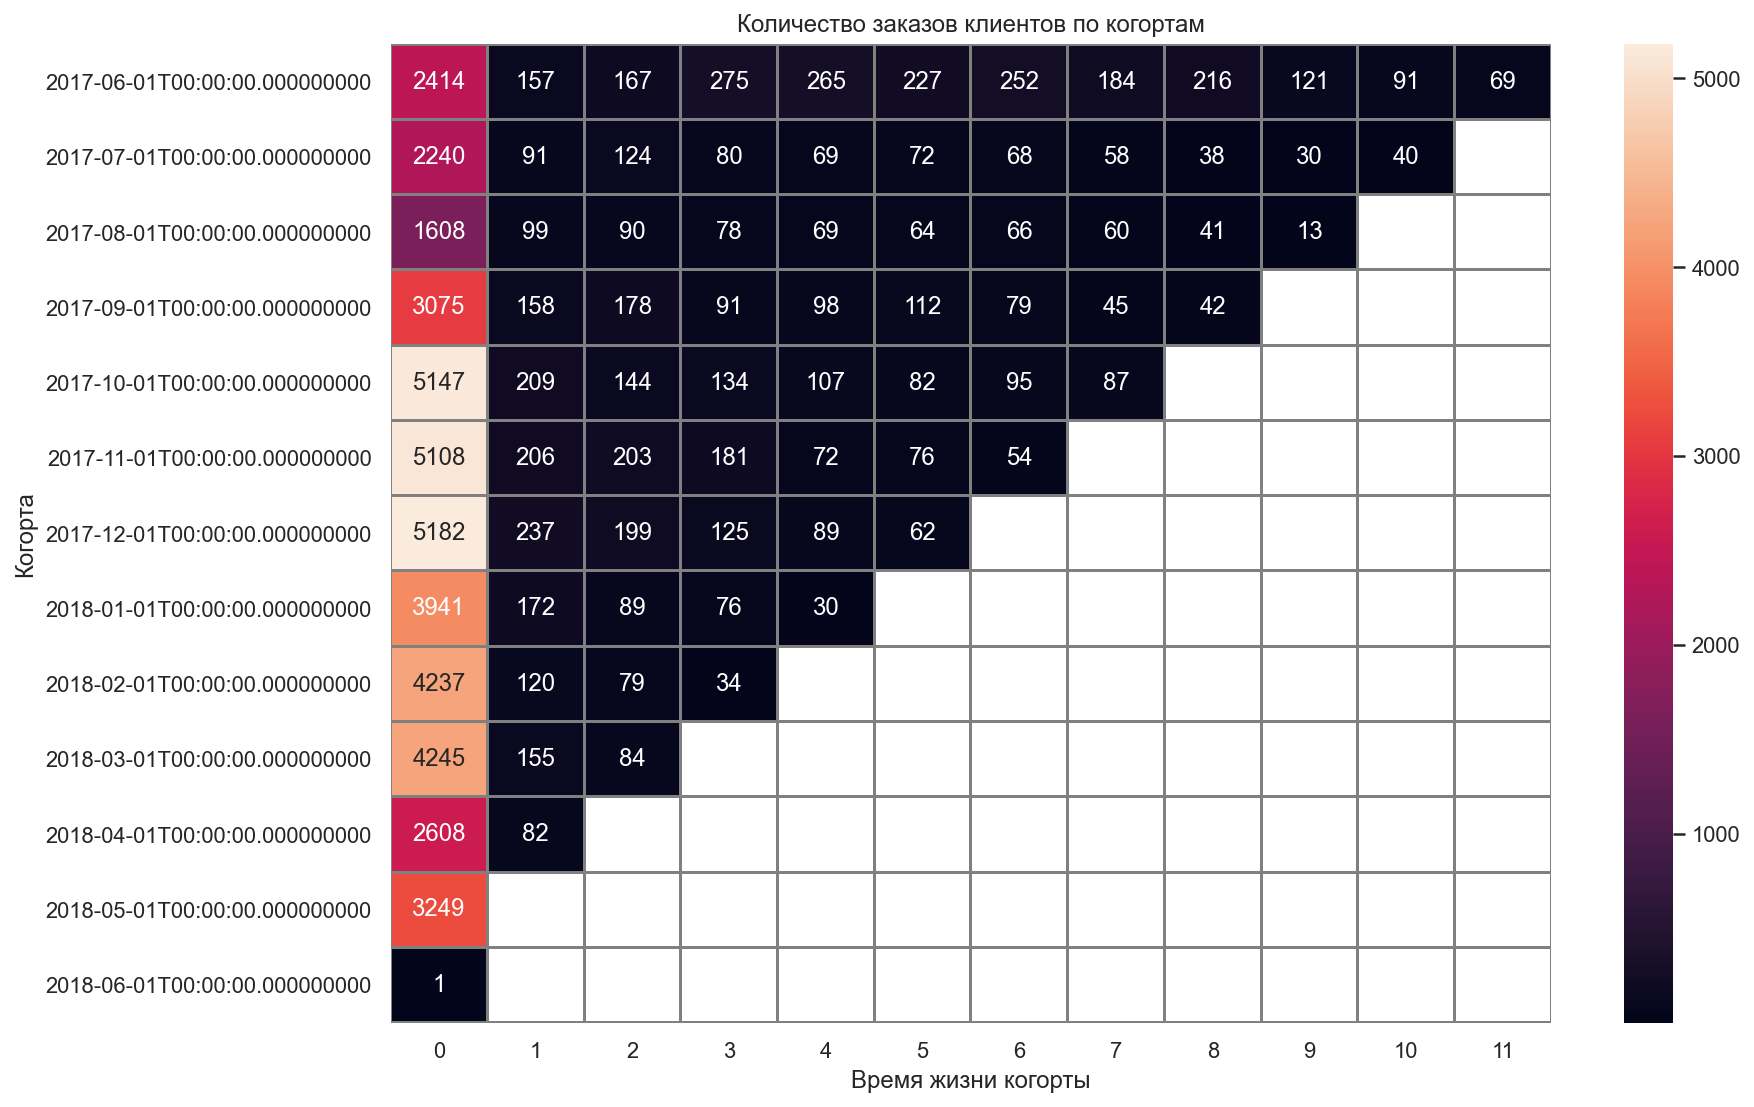

In [135]:
sns.set(style='white');
plt.figure(figsize=(13, 9));
plt.title('Количество заказов клиентов по когортам');
sns.heatmap(orders_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Когорта');

Больше всего заказов было совершено в декабре 2017 года, а также в октябре и ноябре. Меньше всего заказов совершили в августе. Количество заказов по когортам уменьшалось в следующие периоды и было на порядок меньше, чем в первый период.

Расчитаем валовые продажи по когортам.

Посчитаем сколько покупателей в каждой когорте.

In [136]:
cohort_sizes = orders_activity.groupby(['first_order_month']).agg({'uid':'nunique'}).reset_index()

In [137]:
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [138]:
cohort_sizes

first_order_month  n_buyers
0         2017-06-01      2023
1         2017-07-01      1923
2         2017-08-01      1370
3         2017-09-01      2581
4         2017-10-01      4340
5         2017-11-01      4081
6         2017-12-01      4383
7         2018-01-01      3373
8         2018-02-01      3651
9         2018-03-01      3533
10        2018-04-01      2276
11        2018-05-01      2988
12        2018-06-01         1

Посчитаем выручку в каждый месяц для каждой когорты.

In [139]:
cohorts_revenue = orders_activity.groupby(['first_order_month','cohort_lifetime']).agg({'revenue':'sum'}).reset_index()

In [140]:
cohorts_revenue.head()

first_order_month  cohort_lifetime  revenue
0        2017-06-01                0  9921.62
1        2017-06-01                1   835.17
2        2017-06-01                2   947.65
3        2017-06-01                3  2399.24
4        2017-06-01                4  1610.75

Объединим это с данными по количеству покупателей в период.

In [141]:
report_revenue = cohort_sizes.merge(cohorts_revenue, on='first_order_month')

In [142]:
report_revenue.head()

first_order_month  n_buyers  cohort_lifetime  revenue
0        2017-06-01      2023                0  9921.62
1        2017-06-01      2023                1   835.17
2        2017-06-01      2023                2   947.65
3        2017-06-01      2023                3  2399.24
4        2017-06-01      2023                4  1610.75

Примем, что маржинальной равна 100% и вся выручка равняется прибыли компании.

In [143]:
report_revenue['gp'] = report_revenue['revenue']

Посчитаем средний чек по периодам, разделив прибыль на количество продаж.

Расчитаем число покупок по когортам и период.

In [144]:
orders_num = orders_activity.groupby(['first_order_month', 'cohort_lifetime']).agg({'uid':'count'}).reset_index()

In [145]:
orders_num.columns = ['first_order_month', 'cohort_lifetime', 'n_orders']

In [146]:
report_revenue = report_revenue.merge(orders_num, on=['first_order_month', 'cohort_lifetime'])

In [147]:
report_revenue.head()

first_order_month  n_buyers  cohort_lifetime  revenue       gp  n_orders
0        2017-06-01      2023                0  9921.62  9921.62      2414
1        2017-06-01      2023                1   835.17   835.17       157
2        2017-06-01      2023                2   947.65   947.65       167
3        2017-06-01      2023                3  2399.24  2399.24       275
4        2017-06-01      2023                4  1610.75  1610.75       265

Рассчитаем отношение количество заказов к количеству покупателей за период.

In [148]:
cohort_orders_num = report_revenue.groupby('first_order_month')['n_orders'].sum().reset_index()

In [149]:
cohort_orders_num.columns = ['first_order_month', 'cohort_n_orders']

In [150]:
report_revenue = report_revenue.merge(cohort_orders_num, on='first_order_month')

In [151]:
report_revenue['orders_per_buyer'] = report_revenue['cohort_n_orders'] / report_revenue['n_buyers']

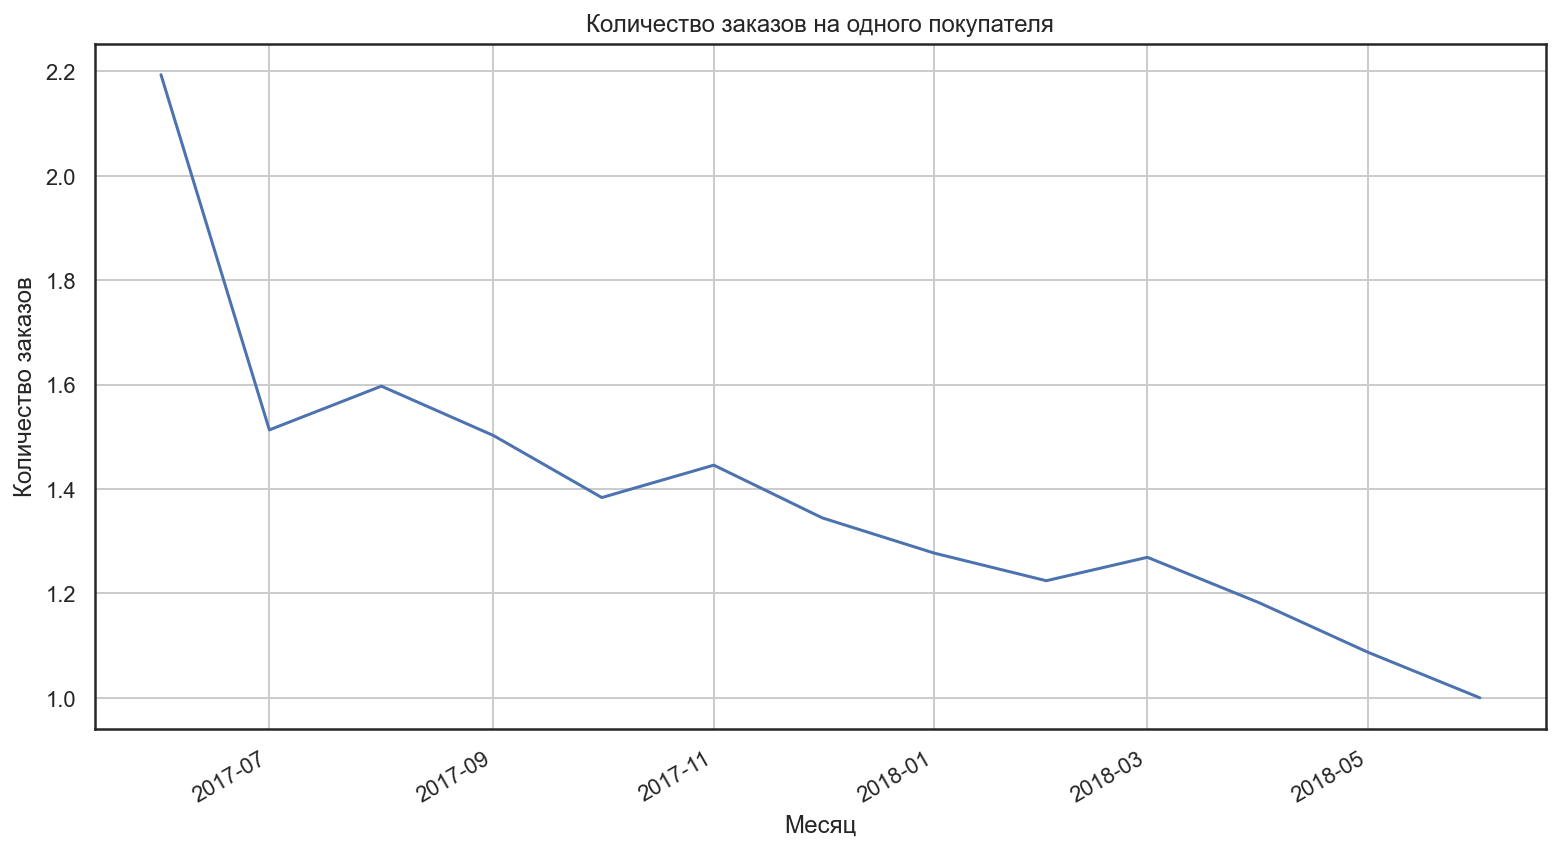

In [152]:
report_revenue[['first_order_month', 'orders_per_buyer']].plot(x='first_order_month', y='orders_per_buyer',
                                                               grid=True, figsize=(13,7), legend=False);
plt.title('Количество заказов на одного покупателя');
plt.xlabel('Месяц');
plt.ylabel('Количество заказов');

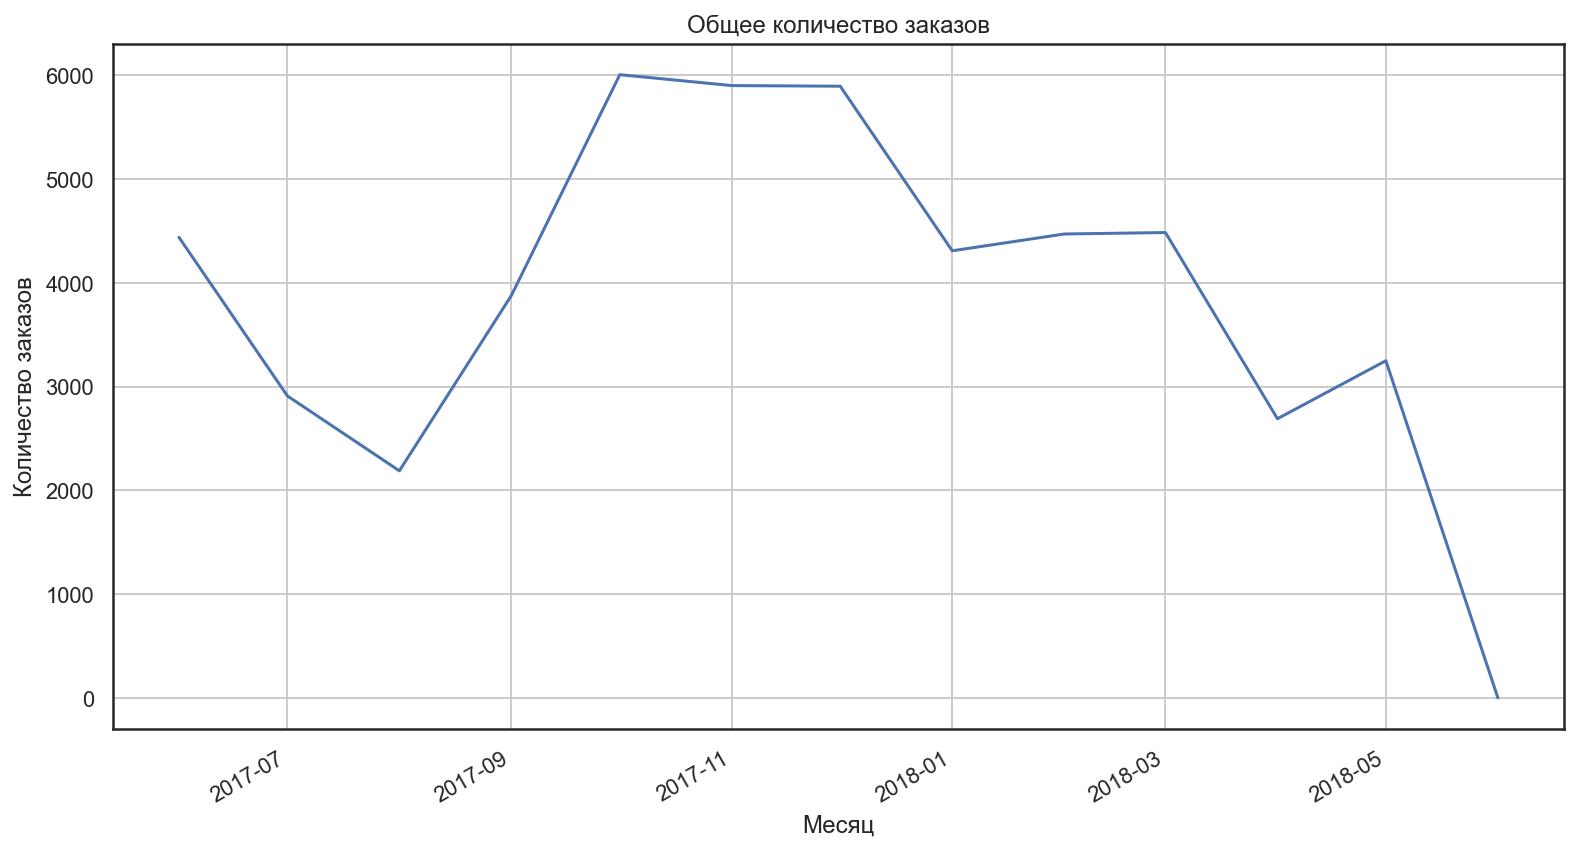

In [153]:
report_revenue[['first_order_month', 'cohort_n_orders']].plot(x='first_order_month', y='cohort_n_orders',
                                                               grid=True, figsize=(13,7), legend=False);
plt.title('Общее количество заказов');
plt.xlabel('Месяц');
plt.ylabel('Количество заказов');

Как видно по графику выше количество заказов на одного покупателя падает, несмотря на то, что общее число заказов росло. Это может быть вызвано тем, что маркетинговые акции привлекали больше уникальных новых покупателей, но не возвращали старых. Таким образом, на текущий момент количество заказов практически равно количеству привлеченных новых пользователей.

In [154]:
report_revenue['mean_bill'] = report_revenue['gp'] / report_revenue['n_orders']

In [155]:
report_revenue

first_order_month  n_buyers  cohort_lifetime   revenue        gp  n_orders  \
0         2017-06-01      2023                0   9921.62   9921.62      2414   
1         2017-06-01      2023                1    835.17    835.17       157   
2         2017-06-01      2023                2    947.65    947.65       167   
3         2017-06-01      2023                3   2399.24   2399.24       275   
4         2017-06-01      2023                4   1610.75   1610.75       265   
..               ...       ...              ...       ...       ...       ...   
74        2018-03-01      3533                2    618.81    618.81        84   
75        2018-04-01      2276                0  11241.17  11241.17      2608   
76        2018-04-01      2276                1    569.44    569.44        82   
77        2018-05-01      2988                0  13925.76  13925.76      3249   
78        2018-06-01         1                0      3.42      3.42         1   

    cohort_n_orders  orders_per_buyer  mean_bill  
0              4438          2.193772   4.110033  
1              4438          2.193772   5.319554  
2              4438          2.193772   5.674551  
3              4438          2.193772   8.724509  
4              4438          2.193772   6.078302  
..              ...               ...        ...  
74             4484          1.269176   7.366786  
75             2690          1.181898   4.310265  
76             2690          1.181898   6.944390  
77             3249          1.087349   4.286168  
78                1          1.000000   3.420000  

[79 rows x 9 columns]

In [156]:
mean_bill_pivot = report_revenue.pivot_table(
        index='first_order_month', 
        columns='cohort_lifetime', 
        values='mean_bill', 
        aggfunc='mean').round(3)

In [157]:
mean_bill_pivot

cohort_lifetime       0       1       2       3       4       5       6   \
first_order_month                                                          
2017-06-01         4.110   5.320   5.675   8.725   6.078   8.543   5.421   
2017-07-01         5.319   6.603  10.535   4.377   4.767   3.793   3.688   
2017-08-01         4.772   6.074   7.364   7.135   7.186   5.669   5.176   
2017-09-01         5.288  12.529  53.202  22.193  17.300  12.550  13.457   
2017-10-01         4.489   6.495   5.101   5.776   4.852   4.161   4.953   
2017-11-01         4.296   5.343   5.440   6.265   3.575   3.802   4.999   
2017-12-01         4.108   7.383  20.907  28.700  27.903   3.468     NaN   
2018-01-01         3.739   4.982   8.502   2.907   3.148     NaN     NaN   
2018-02-01         3.744   3.848   3.747   3.867     NaN     NaN     NaN   
2018-03-01         4.196   5.431   7.367     NaN     NaN     NaN     NaN   
2018-04-01         4.310   6.944     NaN     NaN     NaN     NaN     NaN   
2018-05-01         4.286     NaN     NaN     NaN     NaN     NaN     NaN   
2018-06-01         3.420     NaN     NaN     NaN     NaN     NaN     NaN   

cohort_lifetime       7      8       9       10     11  
first_order_month                                       
2017-06-01         7.016  5.262   9.567  11.200  5.907  
2017-07-01         6.430  4.493  10.952   5.766    NaN  
2017-08-01         9.535  5.599   8.445     NaN    NaN  
2017-09-01         8.248  9.818     NaN     NaN    NaN  
2017-10-01         3.475    NaN     NaN     NaN    NaN  
2017-11-01           NaN    NaN     NaN     NaN    NaN  
2017-12-01           NaN    NaN     NaN     NaN    NaN  
2018-01-01           NaN    NaN     NaN     NaN    NaN  
2018-02-01           NaN    NaN     NaN     NaN    NaN  
2018-03-01           NaN    NaN     NaN     NaN    NaN  
2018-04-01           NaN    NaN     NaN     NaN    NaN  
2018-05-01           NaN    NaN     NaN     NaN    NaN  
2018-06-01           NaN    NaN     NaN     NaN    NaN

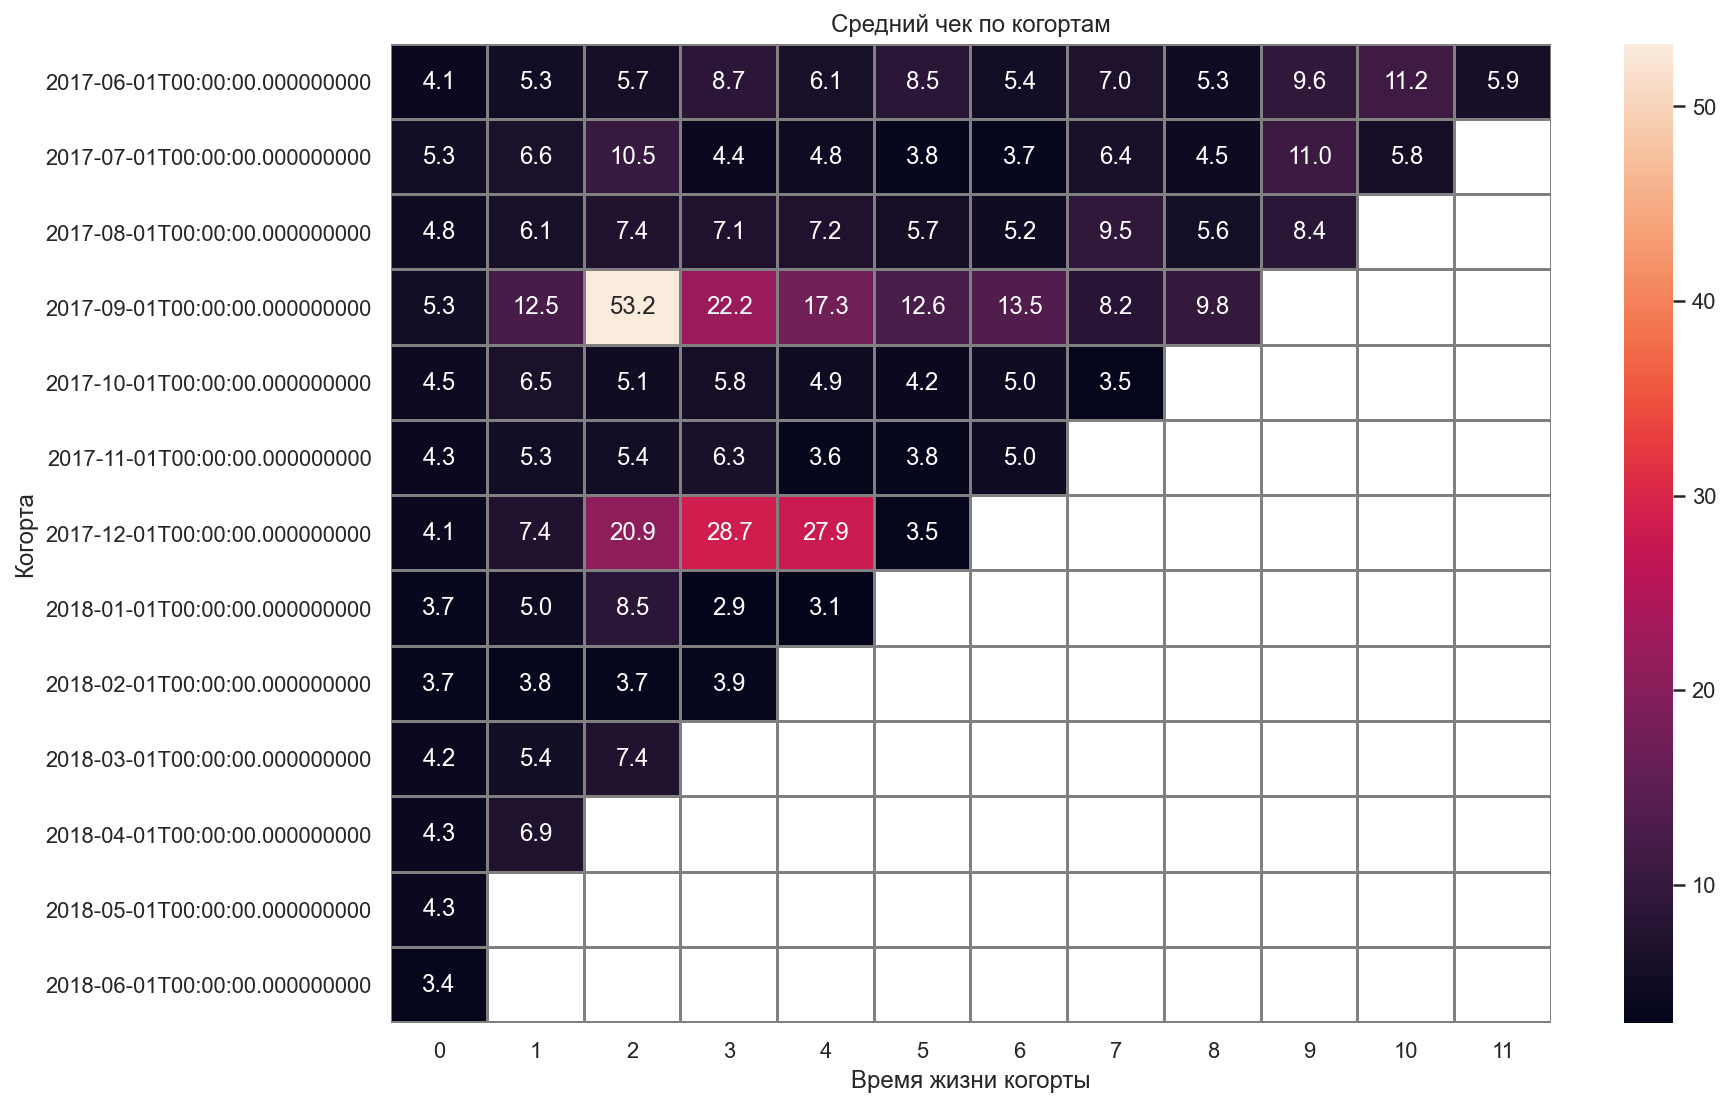

In [158]:
sns.set(style='white');
plt.figure(figsize=(13, 9));
plt.title('Средний чек по когортам');
sns.heatmap(mean_bill_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Когорта');

Наибольший средний чек в размере 53.2 наблюдался для когорты сентября 2017 года в ноябре на третий месяц жизни когорты. Также для когорты клиентов, которые впервые делали заказ в декабре 2017 года, видно, что максимальный средний чек для них был в феврале, марте и апреле 2018 года, что, возможно, связано с праздниками в это время.

Расчитаем LTV Lifetime Value для клиента. Для этого валовую прибыль нужно разделить на количество покупателей.

In [159]:
report_revenue['ltv'] = report_revenue['gp'] / report_revenue['n_buyers']

In [160]:
report_revenue

first_order_month  n_buyers  cohort_lifetime   revenue        gp  n_orders  \
0         2017-06-01      2023                0   9921.62   9921.62      2414   
1         2017-06-01      2023                1    835.17    835.17       157   
2         2017-06-01      2023                2    947.65    947.65       167   
3         2017-06-01      2023                3   2399.24   2399.24       275   
4         2017-06-01      2023                4   1610.75   1610.75       265   
..               ...       ...              ...       ...       ...       ...   
74        2018-03-01      3533                2    618.81    618.81        84   
75        2018-04-01      2276                0  11241.17  11241.17      2608   
76        2018-04-01      2276                1    569.44    569.44        82   
77        2018-05-01      2988                0  13925.76  13925.76      3249   
78        2018-06-01         1                0      3.42      3.42         1   

    cohort_n_orders  orders_per_buyer  mean_bill       ltv  
0              4438          2.193772   4.110033  4.904409  
1              4438          2.193772   5.319554  0.412837  
2              4438          2.193772   5.674551  0.468438  
3              4438          2.193772   8.724509  1.185981  
4              4438          2.193772   6.078302  0.796218  
..              ...               ...        ...       ...  
74             4484          1.269176   7.366786  0.175151  
75             2690          1.181898   4.310265  4.939003  
76             2690          1.181898   6.944390  0.250193  
77             3249          1.087349   4.286168  4.660562  
78                1          1.000000   3.420000  3.420000  

[79 rows x 10 columns]

In [161]:
report_revenue.groupby('first_order_month')['n_orders'].sum()

first_order_month
2017-06-01    4438
2017-07-01    2910
2017-08-01    2188
2017-09-01    3878
2017-10-01    6005
2017-11-01    5900
2017-12-01    5894
2018-01-01    4308
2018-02-01    4470
2018-03-01    4484
2018-04-01    2690
2018-05-01    3249
2018-06-01       1
Name: n_orders, dtype: int64

In [162]:
ltv_pivot = report_revenue.pivot_table(
        index='first_order_month', 
        columns='cohort_lifetime', 
        values='ltv', 
        aggfunc='mean').round(2)

In [163]:
ltv_pivot

cohort_lifetime      0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06-01         4.90  0.41  0.47  1.19  0.80  0.96  0.68  0.64  0.56  0.57   
2017-07-01         6.20  0.31  0.68  0.18  0.17  0.14  0.13  0.19  0.09  0.17   
2017-08-01         5.60  0.44  0.48  0.41  0.36  0.26  0.25  0.42  0.17  0.08   
2017-09-01         6.30  0.77  3.67  0.78  0.66  0.54  0.41  0.14  0.16   NaN   
2017-10-01         5.32  0.31  0.17  0.18  0.12  0.08  0.11  0.07   NaN   NaN   
2017-11-01         5.38  0.27  0.27  0.28  0.06  0.07  0.07   NaN   NaN   NaN   
2017-12-01         4.86  0.40  0.95  0.82  0.57  0.05   NaN   NaN   NaN   NaN   
2018-01-01         4.37  0.25  0.22  0.07  0.03   NaN   NaN   NaN   NaN   NaN   
2018-02-01         4.34  0.13  0.08  0.04   NaN   NaN   NaN   NaN   NaN   NaN   
2018-03-01         5.04  0.24  0.18   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-04-01         4.94  0.25   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-05-01         4.66   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2018-06-01         3.42   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

cohort_lifetime      10   11  
first_order_month             
2017-06-01         0.50  0.2  
2017-07-01         0.12  NaN  
2017-08-01          NaN  NaN  
2017-09-01          NaN  NaN  
2017-10-01          NaN  NaN  
2017-11-01          NaN  NaN  
2017-12-01          NaN  NaN  
2018-01-01          NaN  NaN  
2018-02-01          NaN  NaN  
2018-03-01          NaN  NaN  
2018-04-01          NaN  NaN  
2018-05-01          NaN  NaN  
2018-06-01          NaN  NaN

Для лучшей визуализации посчитаем накопительную сумму LTV по времени жизни когорт.

In [164]:
ltv_report = ltv_pivot.cumsum(axis=1).round(2)

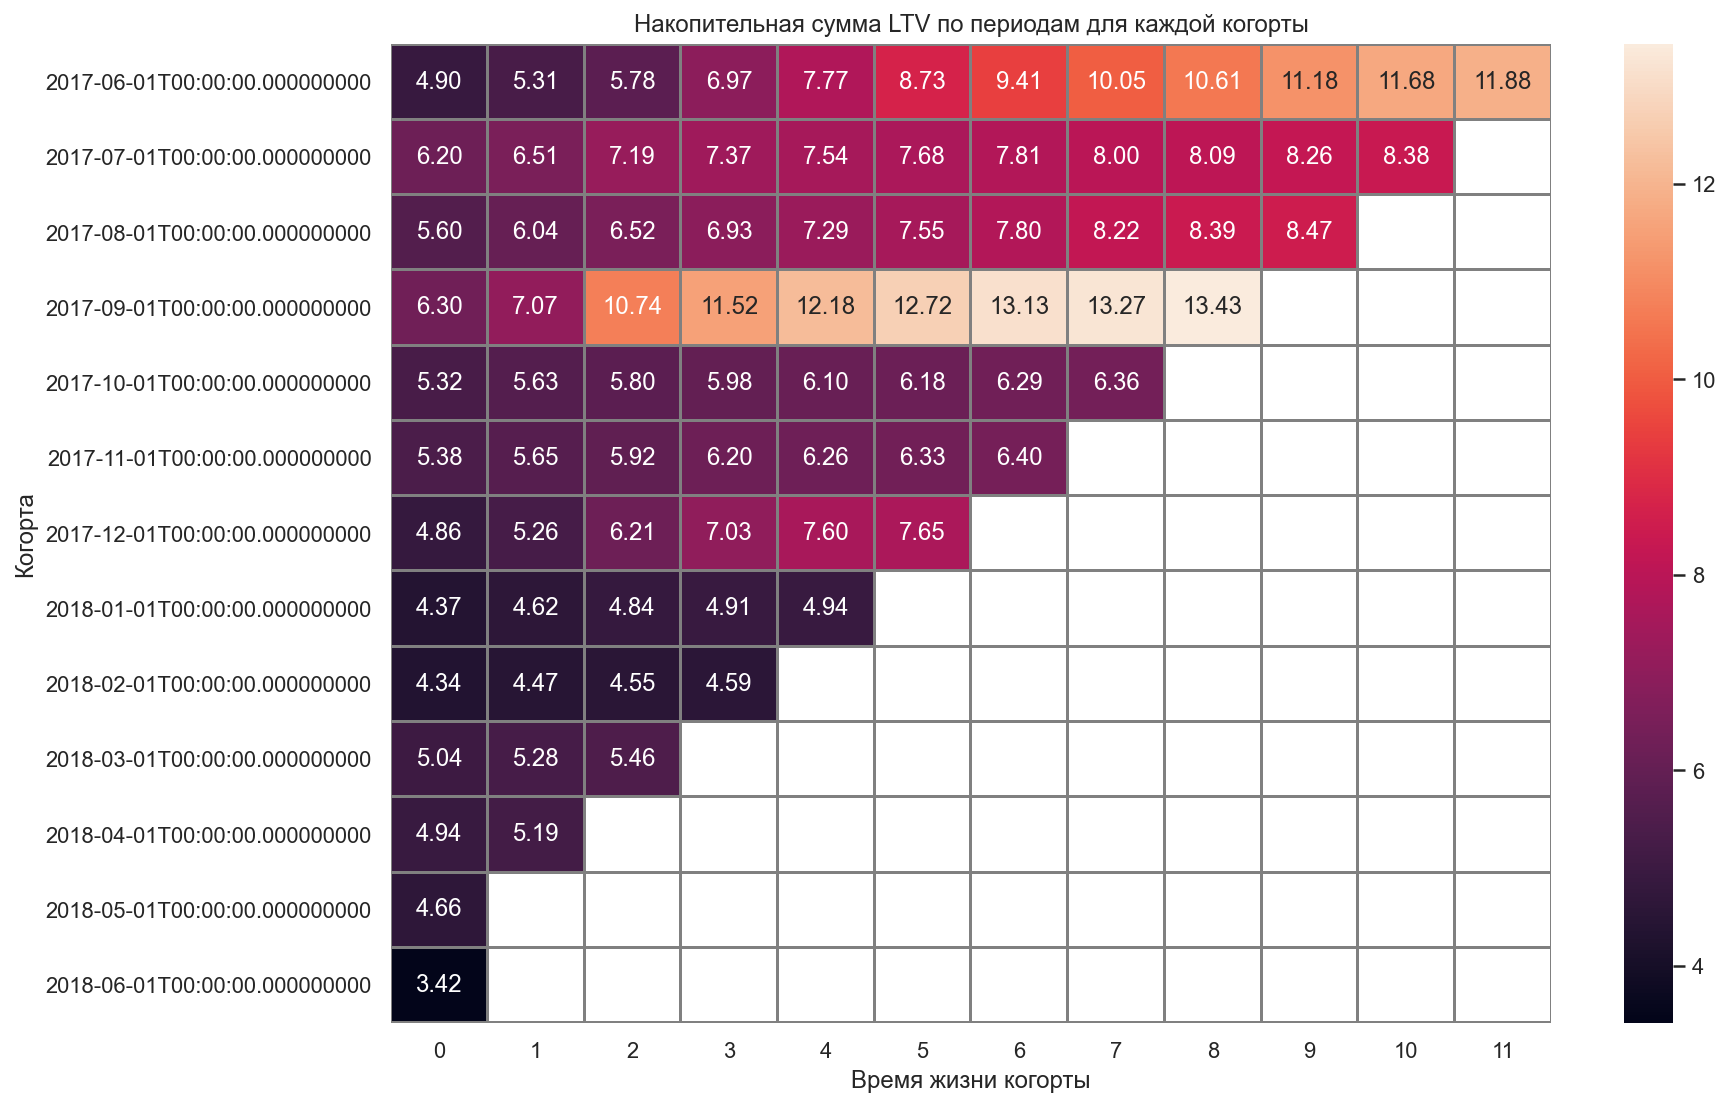

In [165]:
plt.figure(figsize=(13, 9));
plt.title('Накопительная сумма LTV по периодам для каждой когорты');
sns.heatmap(ltv_report, annot=True, fmt='.2f', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Когорта');

Как видно на визуализации с накопительным LTV когорта сентября 2017 уже на второй месяц принесла больше дохода, чем когорта июня 2017 после 4 месяцев, а на третий месяц принесла больше, чем на 7 месяц первый когорты. На втором месте по скорости принесения прибыли когорта июля 2017 года, которая уже на втором периоде принесла больше, чем за 3 периода когорта июня 2017 года.

Как видно по графику, наибольшую прибыль принесла когорта пользователей сентября 2017 года (LTV = 13.4), далее идет первая когорта (которая также может включать все предыдущие периоды) (LTV = 11.9). С течением времени LTV уменьшается.

Если сравнить отдельно когорты, которые прожили как минимум 6 периодов, то среди них также лучшей окажется когорта сентября, затем когорта июня, июля и августа. Когорты октября и ноября показали практически в 2 раза меньший результат, чем когорта сентября за тот же срок.

#### Анализ затрат на маркетинг
*   Сколько денег потратили? Всего / на каждый источник / по времени
*   Сколько стоило привлечение одного покупателя из каждого источника?
*   На сколько окупились расходы? (ROI)

Проанализируем таблицу с расходами.

In [166]:
costs.head()

source_id         dt  costs
0          1 2017-06-01  75.20
1          1 2017-06-02  62.25
2          1 2017-06-03  36.53
3          1 2017-06-04  55.00
4          1 2017-06-05  57.08

Посчитаем общие затраты.

In [167]:
costs['costs'].sum()

329131.62

**Всего затрат за год на 329131.62.**

Рассчитаем траты в месяц по разным источникам.

In [168]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [169]:
costs_monthly = costs.groupby(['source_id', 'month'])['costs'].sum().reset_index()

In [170]:
costs_monthly.head()

source_id      month    costs
0          1 2017-06-01  1125.61
1          1 2017-07-01  1072.88
2          1 2017-08-01   951.81
3          1 2017-09-01  1502.01
4          1 2017-10-01  2315.75

In [171]:
costs.groupby('source_id')['costs'].sum().reset_index()

source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49

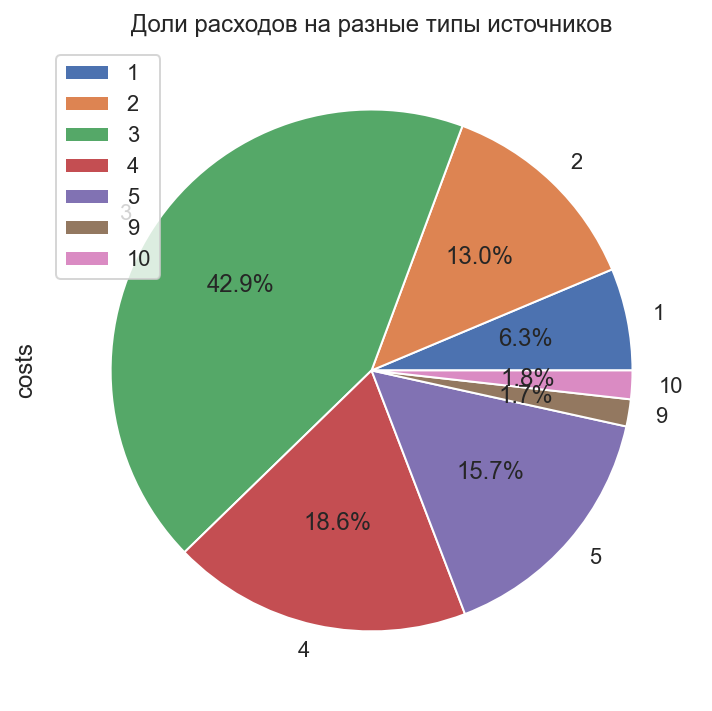

In [172]:
costs.groupby('source_id')['costs'].sum().reset_index().plot(kind='pie', y='costs',
                                    autopct='%1.1f%%', labels=costs['source_id'].unique(),
                                                             figsize=(13,6));
plt.title('Доли расходов на разные типы источников');

In [173]:
costs.groupby('month')['costs'].sum().reset_index()

month     costs
0  2017-06-01  18015.00
1  2017-07-01  18240.59
2  2017-08-01  14790.54
3  2017-09-01  24368.91
4  2017-10-01  36322.88
5  2017-11-01  37907.88
6  2017-12-01  38315.35
7  2018-01-01  33518.52
8  2018-02-01  32723.03
9  2018-03-01  30415.27
10 2018-04-01  22289.38
11 2018-05-01  22224.27

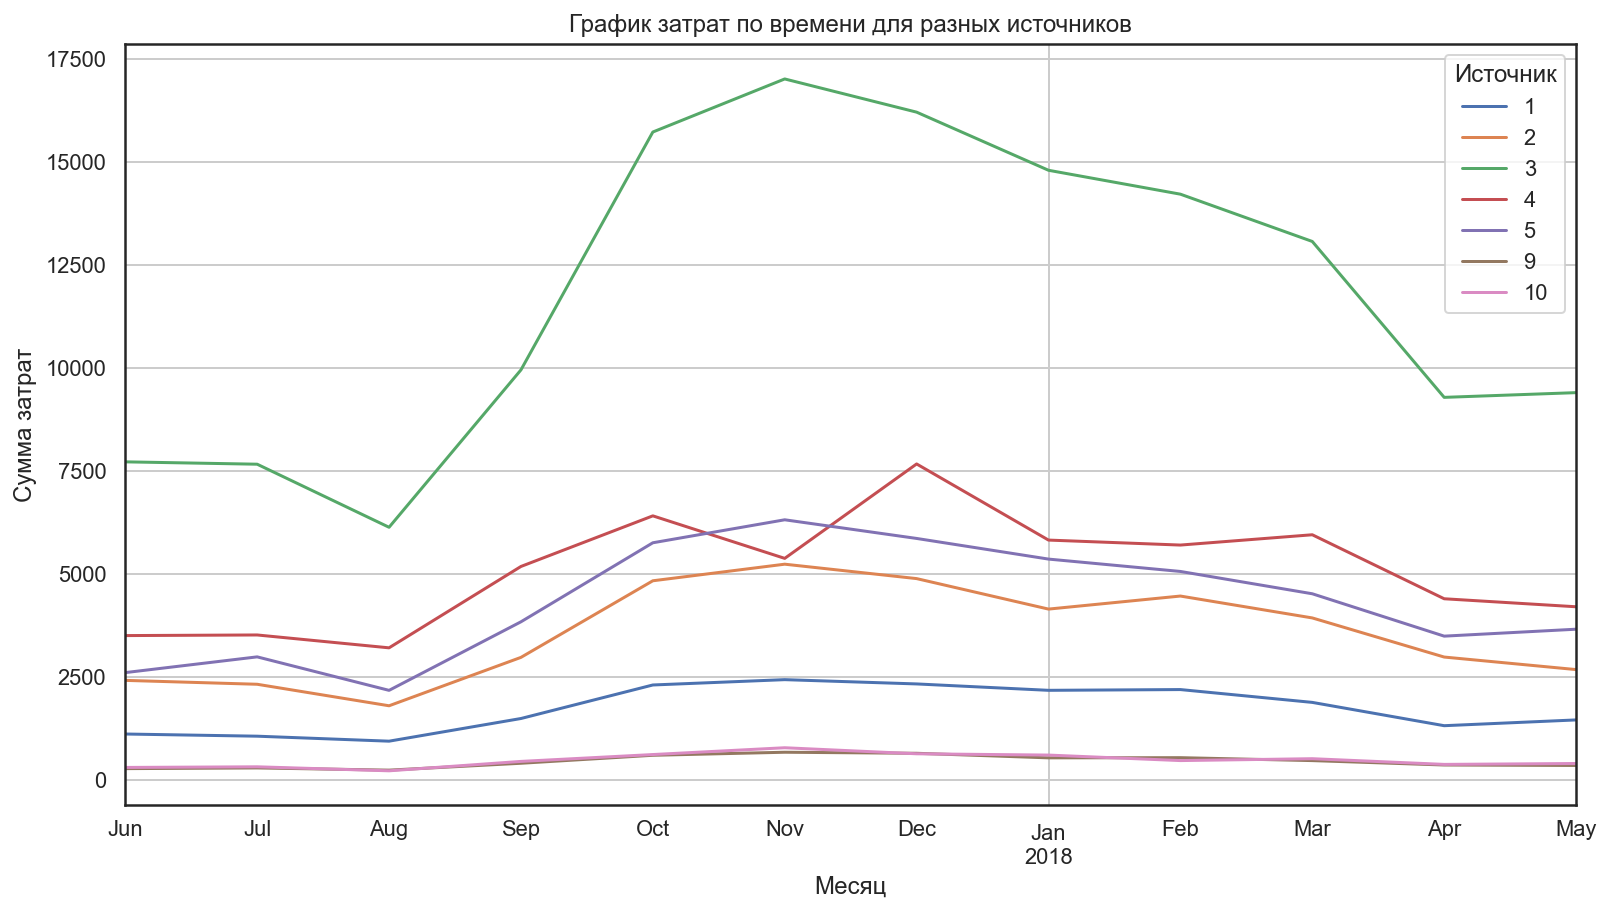

In [174]:
plt.figure(figsize=(13,7));
for label, grp in costs_monthly.groupby('source_id'):
    grp.plot(x='month', y='costs', ax=plt.gca(), label=label, grid=True)
plt.title('График затрат по времени для разных источников');
plt.legend(title="Источник");
plt.xlabel('Месяц');
plt.ylabel('Сумма затрат');

Больше всего затрат было потрачено на источник 3 в размере 141321.63. Затраты по времени были максимальны в ноябре 2017 года и минимальны в августе 2017 года. Судя по графику выше расходы нарастали с сентября 2017 года и убывали, начиная с декабря 2017 года вплоть до конца выборки.

Рассчитаем расходы на привлечение одного клиента. Для этого совместим подготовленный датафрейм с количеством покупателей в каждой когорте

In [175]:
costs_monthly = cohort_sizes.merge(costs_monthly, left_on='first_order_month', right_on='month')

In [176]:
costs_monthly

first_order_month  n_buyers  source_id      month    costs
0         2017-06-01      2023          1 2017-06-01  1125.61
1         2017-06-01      2023          2 2017-06-01  2427.38
2         2017-06-01      2023          3 2017-06-01  7731.65
3         2017-06-01      2023          4 2017-06-01  3514.80
4         2017-06-01      2023          5 2017-06-01  2616.12
..               ...       ...        ...        ...      ...
79        2018-05-01      2988          3 2018-05-01  9411.42
80        2018-05-01      2988          4 2018-05-01  4214.21
81        2018-05-01      2988          5 2018-05-01  3669.56
82        2018-05-01      2988          9 2018-05-01   362.17
83        2018-05-01      2988         10 2018-05-01   409.86

[84 rows x 5 columns]

In [177]:
costs_monthly.groupby('month')['n_buyers'].sum()

month
2017-06-01    14161
2017-07-01    13461
2017-08-01     9590
2017-09-01    18067
2017-10-01    30380
2017-11-01    28567
2017-12-01    30681
2018-01-01    23611
2018-02-01    25557
2018-03-01    24731
2018-04-01    15932
2018-05-01    20916
Name: n_buyers, dtype: int64

Определим откуда пришли пользователи-посетители в первый раз.

In [178]:
visits_sources = visits_log.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})

In [179]:
visits_sources

source_id
uid                            
11863502262781                3
49537067089222                2
297729379853735               3
313578113262317               2
325320750514679               5
...                         ...
18446403737806311543          5
18446424184725333426          4
18446556406699109058          3
18446621818809592527          4
18446676030785672386          3

[228169 rows x 1 columns]

Соединим первые покупки и источники.

In [180]:
buyers_first_time = orders_log.groupby('uid').agg({'buy_ts': 'min'})

In [181]:
buyers_first_time

buy_ts
uid                                     
313578113262317      2018-01-03 21:51:00
1575281904278712     2017-06-03 10:13:00
2429014661409475     2017-10-11 18:33:00
2464366381792757     2018-01-28 15:54:00
2551852515556206     2017-11-24 10:14:00
...                                  ...
18445147675727495770 2017-11-24 09:03:00
18445407535914413204 2017-09-22 23:55:00
18445601152732270159 2018-03-26 22:54:00
18446156210226471712 2018-02-18 19:34:00
18446167067214817906 2017-10-17 10:16:00

[36523 rows x 1 columns]

In [182]:
buyers_first_time = buyers_first_time.merge(visits_sources, on='uid')

In [183]:
buyers_first_time

buy_ts  source_id
uid                                                
313578113262317      2018-01-03 21:51:00          2
1575281904278712     2017-06-03 10:13:00         10
2429014661409475     2017-10-11 18:33:00          3
2464366381792757     2018-01-28 15:54:00          5
2551852515556206     2017-11-24 10:14:00          5
...                                  ...        ...
18445147675727495770 2017-11-24 09:03:00          5
18445407535914413204 2017-09-22 23:55:00          3
18445601152732270159 2018-03-26 22:54:00          2
18446156210226471712 2018-02-18 19:34:00          3
18446167067214817906 2017-10-17 10:16:00          5

[36523 rows x 2 columns]

In [184]:
buyers_first_time = buyers_first_time.rename(columns = {'buy_ts': 'first_order'})

In [185]:
buyers_first_time

first_order  source_id
uid                                                
313578113262317      2018-01-03 21:51:00          2
1575281904278712     2017-06-03 10:13:00         10
2429014661409475     2017-10-11 18:33:00          3
2464366381792757     2018-01-28 15:54:00          5
2551852515556206     2017-11-24 10:14:00          5
...                                  ...        ...
18445147675727495770 2017-11-24 09:03:00          5
18445407535914413204 2017-09-22 23:55:00          3
18445601152732270159 2018-03-26 22:54:00          2
18446156210226471712 2018-02-18 19:34:00          3
18446167067214817906 2017-10-17 10:16:00          5

[36523 rows x 2 columns]

Получили таблицу с распределением первых заказов по источникам для каждого клиента.

Для расчета LTV добавим заказы к таблице с первыми заказами.

In [186]:
ltv_table = buyers_first_time.merge(orders_log, on='uid')

In [187]:
ltv_table.head()

uid         first_order  source_id              buy_ts  \
0   313578113262317 2018-01-03 21:51:00          2 2018-01-03 21:51:00   
1  1575281904278712 2017-06-03 10:13:00         10 2017-06-03 10:13:00   
2  1575281904278712 2017-06-03 10:13:00         10 2017-06-03 17:39:00   
3  2429014661409475 2017-10-11 18:33:00          3 2017-10-11 18:33:00   
4  2464366381792757 2018-01-28 15:54:00          5 2018-01-28 15:54:00   

   revenue  
0     0.55  
1     1.22  
2     1.83  
3    73.33  
4     2.44

Расчитаем время жизни когорты.

In [188]:
ltv_table['cohort_lifetime'] = ((ltv_table['buy_ts'] - ltv_table['first_order']) / np.timedelta64(1,'M')).round().astype(int)

In [189]:
ltv_table

uid         first_order  source_id  \
0           313578113262317 2018-01-03 21:51:00          2   
1          1575281904278712 2017-06-03 10:13:00         10   
2          1575281904278712 2017-06-03 10:13:00         10   
3          2429014661409475 2017-10-11 18:33:00          3   
4          2464366381792757 2018-01-28 15:54:00          5   
...                     ...                 ...        ...   
50410  18445407535914413204 2017-09-22 23:55:00          3   
50411  18445407535914413204 2017-09-22 23:55:00          3   
50412  18445601152732270159 2018-03-26 22:54:00          2   
50413  18446156210226471712 2018-02-18 19:34:00          3   
50414  18446167067214817906 2017-10-17 10:16:00          5   

                   buy_ts  revenue  cohort_lifetime  
0     2018-01-03 21:51:00     0.55                0  
1     2017-06-03 10:13:00     1.22                0  
2     2017-06-03 17:39:00     1.83                0  
3     2017-10-11 18:33:00    73.33                0  
4     2018-01-28 15:54:00     2.44                0  
...                   ...      ...              ...  
50410 2017-09-24 23:48:00     0.24                0  
50411 2017-09-25 15:56:00     0.12                0  
50412 2018-03-26 22:54:00     4.22                0  
50413 2018-02-18 19:34:00     9.78                0  
50414 2017-10-17 10:16:00     7.94                0  

[50415 rows x 6 columns]

Для расчета количества заказов по источникам составим сводную таблицу.

In [190]:
orders_lifetime = ltv_table.pivot_table(index='source_id', columns='cohort_lifetime', values='revenue', aggfunc='count').fillna(0)

In [191]:
orders_lifetime

cohort_lifetime       0      1      2      3      4      5      6      7   \
source_id                                                                   
1                 3498.0  284.0  247.0  242.0  189.0  140.0  185.0  137.0   
2                 4380.0  621.0  398.0  283.0  177.0  149.0  105.0   75.0   
3                11708.0  493.0  331.0  214.0  157.0  111.0  105.0   72.0   
4                11550.0  341.0  236.0  188.0  167.0  120.0  122.0   63.0   
5                 7956.0  283.0  245.0  196.0  153.0  145.0  142.0  119.0   
7                    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9                 1272.0   81.0   59.0   69.0   46.0   39.0   34.0   16.0   
10                1469.0   29.0   13.0   23.0    7.0    2.0    7.0    6.0   

cohort_lifetime     8     9     10    11    12  
source_id                                       
1                109.0  86.0  62.0  34.0  10.0  
2                100.0  41.0  40.0  16.0   7.0  
3                 48.0  16.0  15.0   8.0  11.0  
4                 46.0  30.0  18.0   8.0   6.0  
5                 80.0  60.0  16.0   9.0   2.0  
7                  0.0   0.0   0.0   0.0   0.0  
9                 19.0   9.0   3.0   0.0   0.0  
10                 4.0   2.0   0.0   0.0   0.0

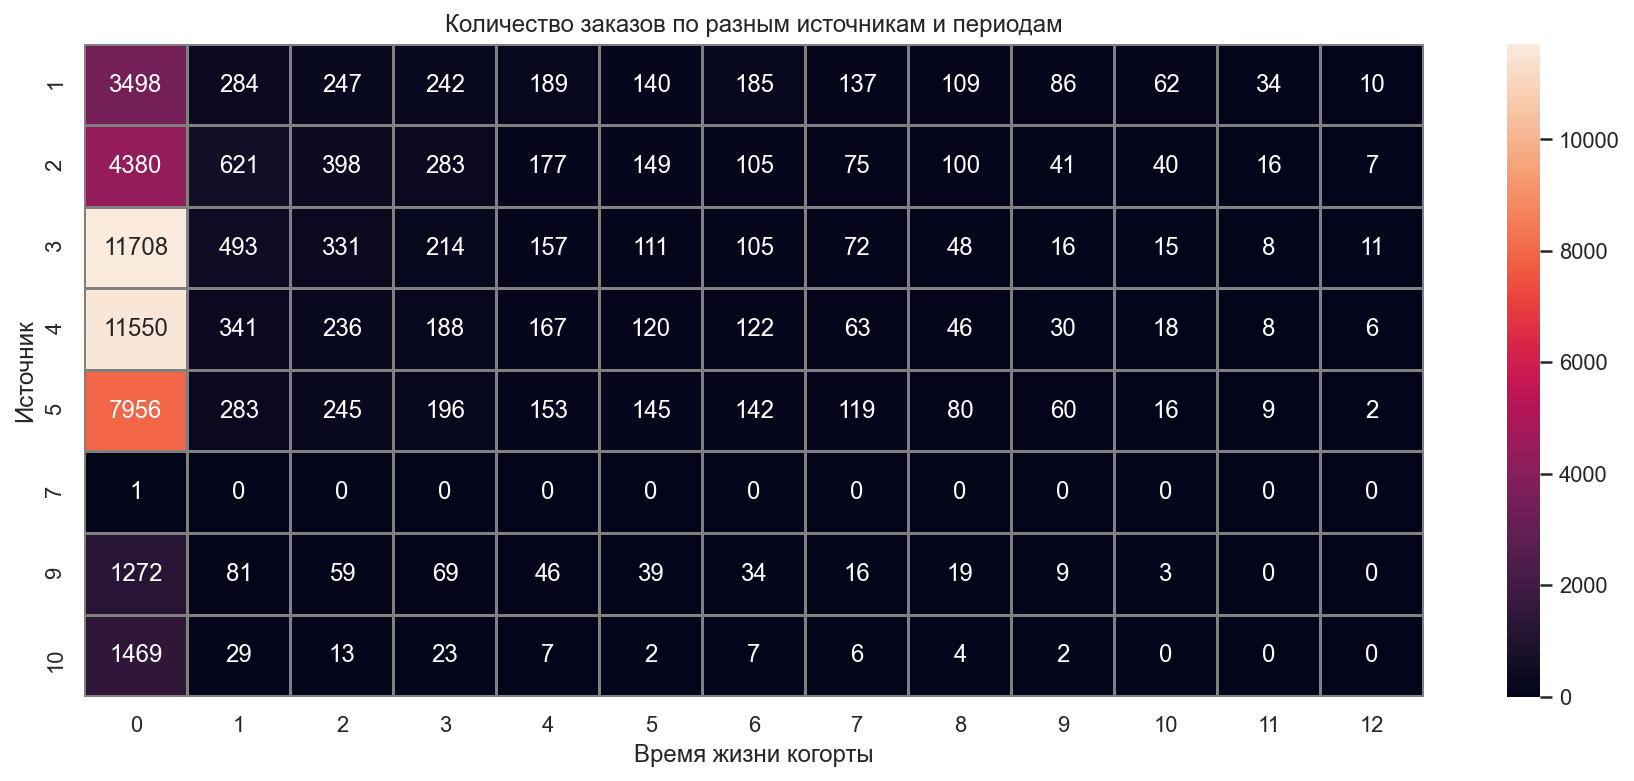

In [192]:
plt.figure(figsize=(15, 6));
plt.title('Количество заказов по разным источникам и периодам');
sns.heatmap(orders_lifetime, annot=True, fmt='.0f', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Источник');

Больше всего заказов было размещено после источника трафика 3, затем 4 и 5. Продаж через источники 6,7,8 практически не было. На второй месяц продажи уменьшались практически на порядок для всех источников.

Теперь рассчитаем количество покупателей по источникам и времени жизни когорты.

In [193]:
buyers_lifetime = ltv_table.pivot_table(index='source_id', columns='cohort_lifetime', values='uid', aggfunc='nunique').fillna(0)

In [194]:
buyers_lifetime

cohort_lifetime       0      1      2      3      4     5     6     7     8   \
source_id                                                                      
1                 2899.0  110.0   92.0   59.0   57.0  39.0  45.0  33.0  23.0   
2                 3506.0  159.0  132.0   99.0   88.0  75.0  55.0  36.0  29.0   
3                10473.0  286.0  227.0  149.0  111.0  86.0  87.0  59.0  45.0   
4                10296.0  272.0  189.0  153.0  110.0  85.0  79.0  40.0  37.0   
5                 6931.0  175.0  124.0   79.0   79.0  59.0  47.0  34.0  25.0   
7                    1.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   
9                 1088.0   68.0   52.0   45.0   37.0  27.0  23.0  11.0  13.0   
10                1329.0   26.0   12.0   19.0    6.0   2.0   7.0   5.0   4.0   

cohort_lifetime    9     10    11   12  
source_id                               
1                14.0  15.0  10.0  6.0  
2                17.0  18.0   9.0  5.0  
3                14.0  15.0   8.0  8.0  
4                23.0  12.0   7.0  5.0  
5                19.0   7.0   6.0  2.0  
7                 0.0   0.0   0.0  0.0  
9                 8.0   3.0   0.0  0.0  
10                1.0   0.0   0.0  0.0

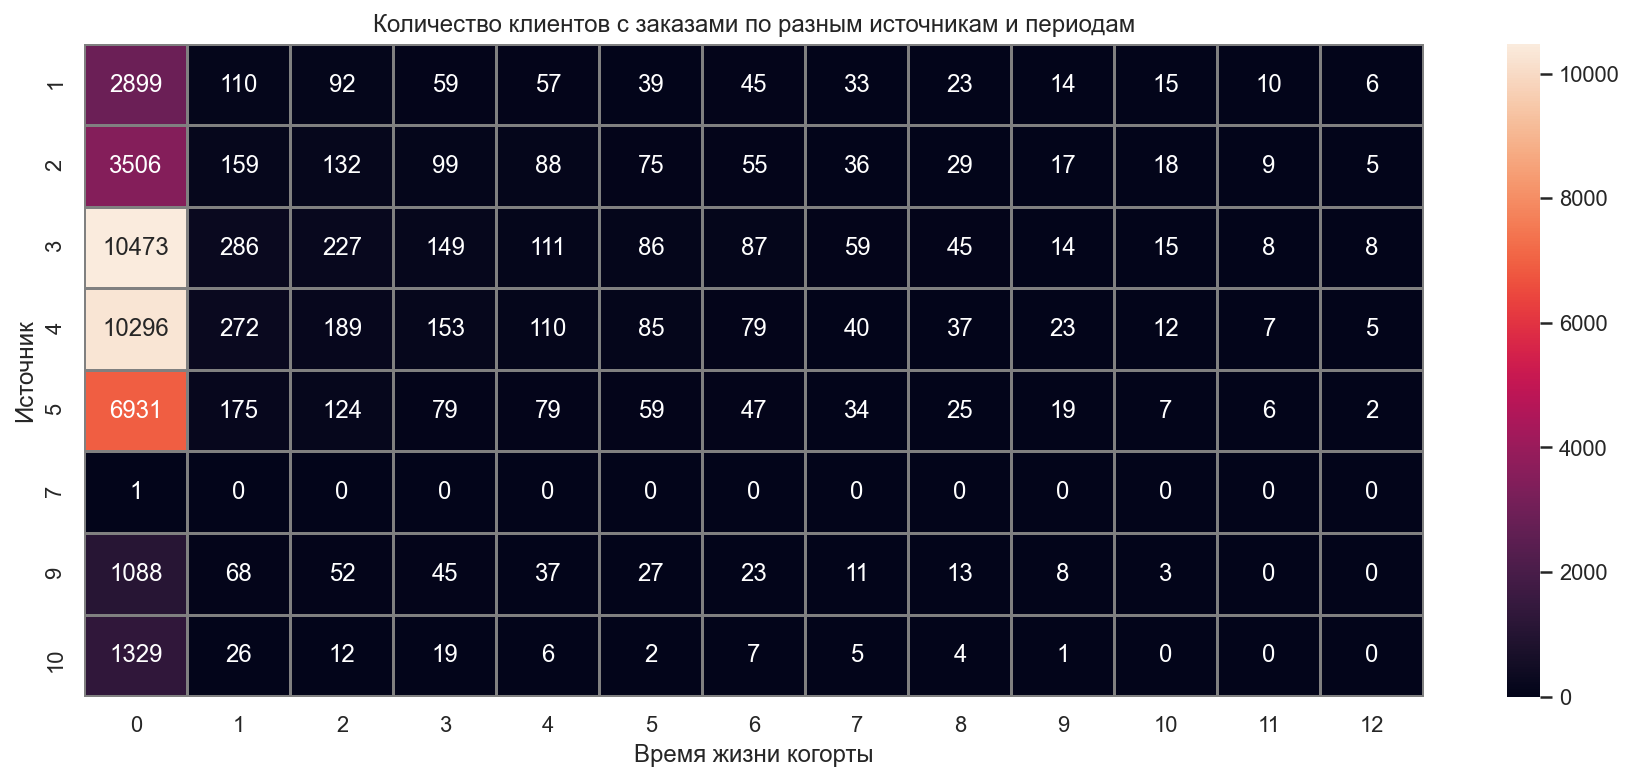

In [195]:
plt.figure(figsize=(15, 6));
plt.title('Количество клиентов с заказами по разным источникам и периодам');
sns.heatmap(buyers_lifetime, annot=True, fmt='.0f', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Источник');

Видно, что количество клиентов с заказами повторяет распределение количества заказов по источникам.

Для расчета LTV сначала расчитаем доход по источникам и времени жизни когорт.

In [196]:
ltv_results = ltv_table.pivot_table(index='source_id', columns='cohort_lifetime', values='revenue', aggfunc='sum').fillna(0)

In [197]:
ltv_results

cohort_lifetime        0        1        2        3        4        5   \
source_id                                                                
1                17846.78  2883.49  2146.19  1874.49  1425.00   642.94   
2                23737.70  4502.22  5831.11  5384.22  2266.59  2048.43   
3                46894.89  2634.89  1429.20  1491.36   784.89   413.65   
4                47204.71  1579.06  1175.28   991.91  1232.90  1628.83   
5                34030.40  1416.06  2465.93  9473.11  1635.71  1203.14   
7                    1.22     0.00     0.00     0.00     0.00     0.00   
9                 4222.42   311.70   261.81   294.70   118.92   160.37   
10                4205.13    84.13    36.23    63.61    18.63     3.51   

cohort_lifetime       6       7       8       9       10      11      12  
source_id                                                                 
1                 796.48  988.65  940.43  752.60  309.32  336.13  148.05  
2                 831.02  795.73  781.76  218.08  397.70  117.20   11.85  
3                 255.68  279.28  195.68   53.66   54.69   11.88   11.49  
4                1192.28  501.02  198.87  390.26  559.93   28.34   13.44  
5                 823.87  622.37  416.77  423.77   44.88   66.24    1.77  
7                   0.00    0.00    0.00    0.00    0.00    0.00    0.00  
9                 134.41   73.42  128.19   44.11    9.35    0.00    0.00  
10                 17.95   14.12    3.66    3.36    0.00    0.00    0.00

Для получения LTV нужно получить кумулятивную сумму по строкам.

In [198]:
ltv_results = ltv_results.cumsum(axis=1)

In [199]:
ltv_results

cohort_lifetime        0         1         2         3         4         5   \
source_id                                                                     
1                17846.78  20730.27  22876.46  24750.95  26175.95  26818.89   
2                23737.70  28239.92  34071.03  39455.25  41721.84  43770.27   
3                46894.89  49529.78  50958.98  52450.34  53235.23  53648.88   
4                47204.71  48783.77  49959.05  50950.96  52183.86  53812.69   
5                34030.40  35446.46  37912.39  47385.50  49021.21  50224.35   
7                    1.22      1.22      1.22      1.22      1.22      1.22   
9                 4222.42   4534.12   4795.93   5090.63   5209.55   5369.92   
10                4205.13   4289.26   4325.49   4389.10   4407.73   4411.24   

cohort_lifetime        6         7         8         9         10        11  \
source_id                                                                     
1                27615.37  28604.02  29544.45  30297.05  30606.37  30942.50   
2                44601.29  45397.02  46178.78  46396.86  46794.56  46911.76   
3                53904.56  54183.84  54379.52  54433.18  54487.87  54499.75   
4                55004.97  55505.99  55704.86  56095.12  56655.05  56683.39   
5                51048.22  51670.59  52087.36  52511.13  52556.01  52622.25   
7                    1.22      1.22      1.22      1.22      1.22      1.22   
9                 5504.33   5577.75   5705.94   5750.05   5759.40   5759.40   
10                4429.19   4443.31   4446.97   4450.33   4450.33   4450.33   

cohort_lifetime        12  
source_id                  
1                31090.55  
2                46923.61  
3                54511.24  
4                56696.83  
5                52624.02  
7                    1.22  
9                 5759.40  
10                4450.33

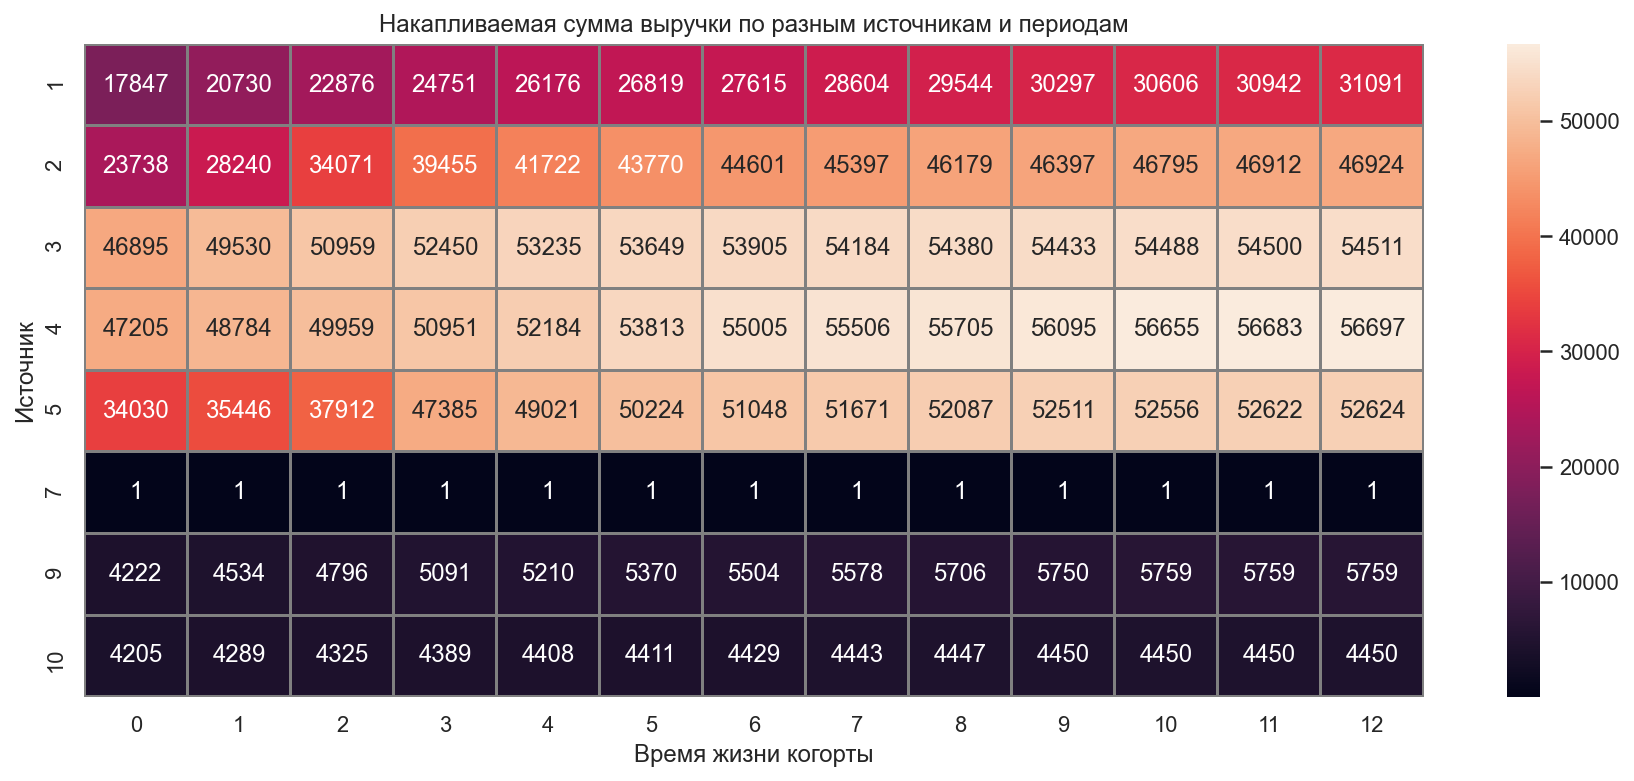

In [200]:
plt.figure(figsize=(15, 6));
plt.title('Накапливаемая сумма выручки по разным источникам и периодам');
sns.heatmap(ltv_results, annot=True, fmt='.0f', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Источник');

Как видно по тепловой карте больше всего выручки принес источник 4, затем 3, 5. Источники 9 и 10 сильно отстают от других источников по прибыли. Видно, что между 2 и 3 периодом (август-сентябрь 2017) произошло резкое увеличение выручки по источнику 5 (на 10 тыс.). Это, по-видимому, связано с увеличением бюджета на этот источник и привлечением новых пользователей через этот канал.

Далее для расчета LTV получим количество покупателей в каждый период по источникам.

In [201]:
cohort_buyers = buyers_first_time.reset_index().groupby('source_id').agg({'uid':'nunique'})

In [202]:
cohort_buyers

uid
source_id       
1           2899
2           3506
3          10473
4          10296
5           6931
7              1
9           1088
10          1329

In [203]:
cohort_buyers = cohort_buyers.rename(columns = {'uid':'cohort_size'})

Получившееся количество покупателей добавим к таблице для расчета LTV.

In [204]:
ltv_output = ltv_results.merge(cohort_buyers, on = 'source_id')

In [205]:
ltv_output

0         1         2         3         4         5  \
source_id                                                               
1          17846.78  20730.27  22876.46  24750.95  26175.95  26818.89   
2          23737.70  28239.92  34071.03  39455.25  41721.84  43770.27   
3          46894.89  49529.78  50958.98  52450.34  53235.23  53648.88   
4          47204.71  48783.77  49959.05  50950.96  52183.86  53812.69   
5          34030.40  35446.46  37912.39  47385.50  49021.21  50224.35   
7              1.22      1.22      1.22      1.22      1.22      1.22   
9           4222.42   4534.12   4795.93   5090.63   5209.55   5369.92   
10          4205.13   4289.26   4325.49   4389.10   4407.73   4411.24   

                  6         7         8         9        10        11  \
source_id                                                               
1          27615.37  28604.02  29544.45  30297.05  30606.37  30942.50   
2          44601.29  45397.02  46178.78  46396.86  46794.56  46911.76   
3          53904.56  54183.84  54379.52  54433.18  54487.87  54499.75   
4          55004.97  55505.99  55704.86  56095.12  56655.05  56683.39   
5          51048.22  51670.59  52087.36  52511.13  52556.01  52622.25   
7              1.22      1.22      1.22      1.22      1.22      1.22   
9           5504.33   5577.75   5705.94   5750.05   5759.40   5759.40   
10          4429.19   4443.31   4446.97   4450.33   4450.33   4450.33   

                 12  cohort_size  
source_id                         
1          31090.55         2899  
2          46923.61         3506  
3          54511.24        10473  
4          56696.83        10296  
5          52624.02         6931  
7              1.22            1  
9           5759.40         1088  
10          4450.33         1329

Теперь можно разделить кумулятивную сумму на количество покупателей по-элементно.

In [206]:
ltv_output = ltv_output.div(ltv_output['cohort_size'], axis=0)

In [207]:
# Столбец с размерами больше не нужен.
ltv_output = ltv_output.drop(columns = 'cohort_size')

In [208]:
ltv_output

0         1         2          3          4          5   \
source_id                                                                  
1          6.156185  7.150835  7.891156   8.537754   9.029303   9.251083   
2          6.770593  8.054740  9.717921  11.253637  11.900125  12.484390   
3          4.477694  4.729283  4.865748   5.008149   5.083093   5.122590   
4          4.584762  4.738128  4.852278   4.948617   5.068362   5.226563   
5          4.909883  5.114191  5.469974   6.836748   7.072747   7.246335   
7          1.220000  1.220000  1.220000   1.220000   1.220000   1.220000   
9          3.880901  4.167390  4.408024   4.678888   4.788189   4.935588   
10         3.164131  3.227434  3.254695   3.302558   3.316576   3.319217   

                  6          7          8          9          10         11  \
source_id                                                                     
1           9.525826   9.866858  10.191256  10.450862  10.557561  10.673508   
2          12.721418  12.948380  13.171358  13.233560  13.346994  13.380422   
3           5.147003   5.173669   5.192354   5.197477   5.202699   5.203834   
4           5.342363   5.391025   5.410340   5.448244   5.502627   5.505380   
5           7.365203   7.454998   7.515129   7.576270   7.582746   7.592303   
7           1.220000   1.220000   1.220000   1.220000   1.220000   1.220000   
9           5.059127   5.126608   5.244430   5.284972   5.293566   5.293566   
10          3.332724   3.343348   3.346102   3.348631   3.348631   3.348631   

                  12  
source_id             
1          10.724577  
2          13.383802  
3           5.204931  
4           5.506685  
5           7.592558  
7           1.220000  
9           5.293566  
10          3.348631

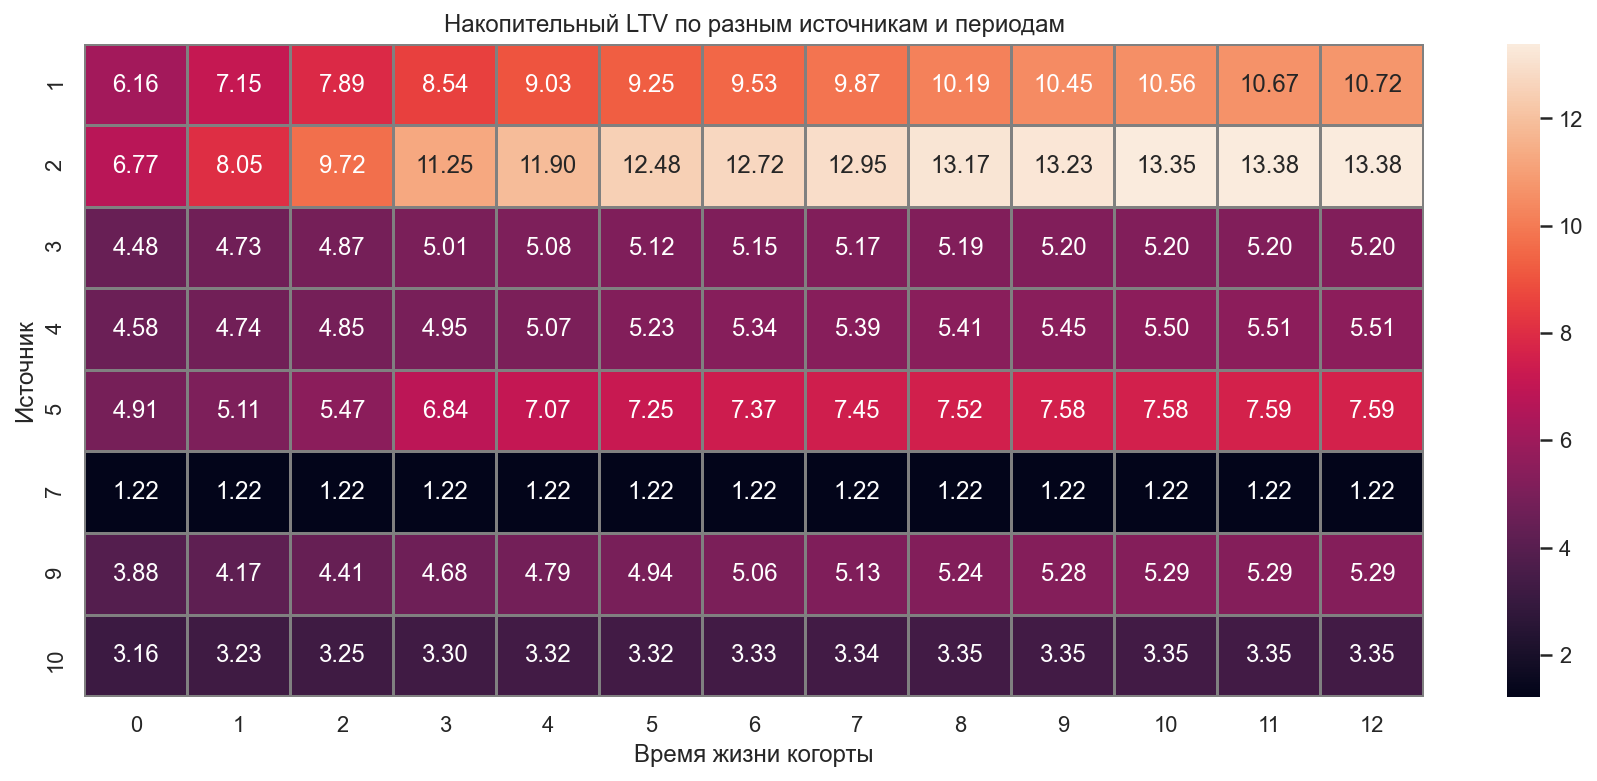

In [209]:
plt.figure(figsize=(15, 6));
plt.title('Накопительный LTV по разным источникам и периодам');
sns.heatmap(ltv_output, annot=True, fmt='.2f', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Источник');

По распределению видно, что наибольший LTV у источника 2, затем 1 и 5 на конец выборки. В то же время, скорость изменения LTV различна по каналам. Так, например, источники 1 и 2 быстрее других наращивали LTV, а на 3 период (сентябрь 2017) источник 5 резко увеличил LTV.

Посчитаем CAC из таблицы с затратами по источникам.

In [210]:
cac_table = costs.groupby('source_id').agg({'costs': 'sum'})

In [211]:
cac_table

costs
source_id           
1           20833.27
2           42806.04
3          141321.63
4           61073.60
5           51757.10
9            5517.49
10           5822.49

Совместим эту таблицу с количеством покупателей по источникам.

In [212]:
cac_table = cac_table.reset_index().merge(cohort_buyers.reset_index(), on='source_id')

In [213]:
cac_table

source_id      costs  cohort_size
0          1   20833.27         2899
1          2   42806.04         3506
2          3  141321.63        10473
3          4   61073.60        10296
4          5   51757.10         6931
5          9    5517.49         1088
6         10    5822.49         1329

In [214]:
cac_table['cac'] = cac_table['costs'] / cac_table['cohort_size']

In [215]:
cac_table

source_id      costs  cohort_size        cac
0          1   20833.27         2899   7.186364
1          2   42806.04         3506  12.209367
2          3  141321.63        10473  13.493901
3          4   61073.60        10296   5.931779
4          5   51757.10         6931   7.467479
5          9    5517.49         1088   5.071222
6         10    5822.49         1329   4.381106

Сделаем индексом `source_id` по примеру других таблиц.

In [216]:
cac_table = cac_table.set_index('source_id')

In [217]:
cac_table

costs  cohort_size        cac
source_id                                   
1           20833.27         2899   7.186364
2           42806.04         3506  12.209367
3          141321.63        10473  13.493901
4           61073.60        10296   5.931779
5           51757.10         6931   7.467479
9            5517.49         1088   5.071222
10           5822.49         1329   4.381106

Наконец все готово для расчета ROMI.

In [218]:
romi_table = ltv_output.merge(cac_table[['cac']], on='source_id')

In [219]:
romi_table

0         1         2          3          4          5  \
source_id                                                                  
1          6.156185  7.150835  7.891156   8.537754   9.029303   9.251083   
2          6.770593  8.054740  9.717921  11.253637  11.900125  12.484390   
3          4.477694  4.729283  4.865748   5.008149   5.083093   5.122590   
4          4.584762  4.738128  4.852278   4.948617   5.068362   5.226563   
5          4.909883  5.114191  5.469974   6.836748   7.072747   7.246335   
9          3.880901  4.167390  4.408024   4.678888   4.788189   4.935588   
10         3.164131  3.227434  3.254695   3.302558   3.316576   3.319217   

                   6          7          8          9         10         11  \
source_id                                                                     
1           9.525826   9.866858  10.191256  10.450862  10.557561  10.673508   
2          12.721418  12.948380  13.171358  13.233560  13.346994  13.380422   
3           5.147003   5.173669   5.192354   5.197477   5.202699   5.203834   
4           5.342363   5.391025   5.410340   5.448244   5.502627   5.505380   
5           7.365203   7.454998   7.515129   7.576270   7.582746   7.592303   
9           5.059127   5.126608   5.244430   5.284972   5.293566   5.293566   
10          3.332724   3.343348   3.346102   3.348631   3.348631   3.348631   

                  12        cac  
source_id                        
1          10.724577   7.186364  
2          13.383802  12.209367  
3           5.204931  13.493901  
4           5.506685   5.931779  
5           7.592558   7.467479  
9           5.293566   5.071222  
10          3.348631   4.381106

Теперь разделим таблицу с LTV на CAC, чтобы получить ROMI. Последний столбец также удалим.

In [220]:
romi_table = romi_table.div(romi_table['cac'], axis=0).drop(columns='cac')

In [221]:
romi_table

0         1         2         3         4         5   \
source_id                                                               
1          0.856648  0.995056  1.098073  1.188049  1.256449  1.287311   
2          0.554541  0.659718  0.795940  0.921722  0.974672  1.022526   
3          0.331831  0.350476  0.360589  0.371142  0.376696  0.379623   
4          0.772915  0.798770  0.818014  0.834255  0.854442  0.881112   
5          0.657502  0.684862  0.732506  0.915536  0.947140  0.970386   
9          0.765279  0.821772  0.869223  0.922635  0.944188  0.973254   
10         0.722222  0.736671  0.742894  0.753818  0.757018  0.757621   

                 6         7         8         9         10        11  \
source_id                                                               
1          1.325542  1.372997  1.418138  1.454263  1.469110  1.485245   
2          1.041939  1.060528  1.078791  1.083886  1.093177  1.095915   
3          0.381432  0.383408  0.384793  0.385172  0.385559  0.385643   
4          0.900634  0.908838  0.912094  0.918484  0.927652  0.928116   
5          0.986304  0.998329  1.006381  1.014569  1.015436  1.016716   
9          0.997615  1.010922  1.034155  1.042150  1.043844  1.043844   
10         0.760704  0.763129  0.763757  0.764335  0.764335  0.764335   

                 12  
source_id            
1          1.492351  
2          1.096191  
3          0.385725  
4          0.928336  
5          1.016750  
9          1.043844  
10         0.764335

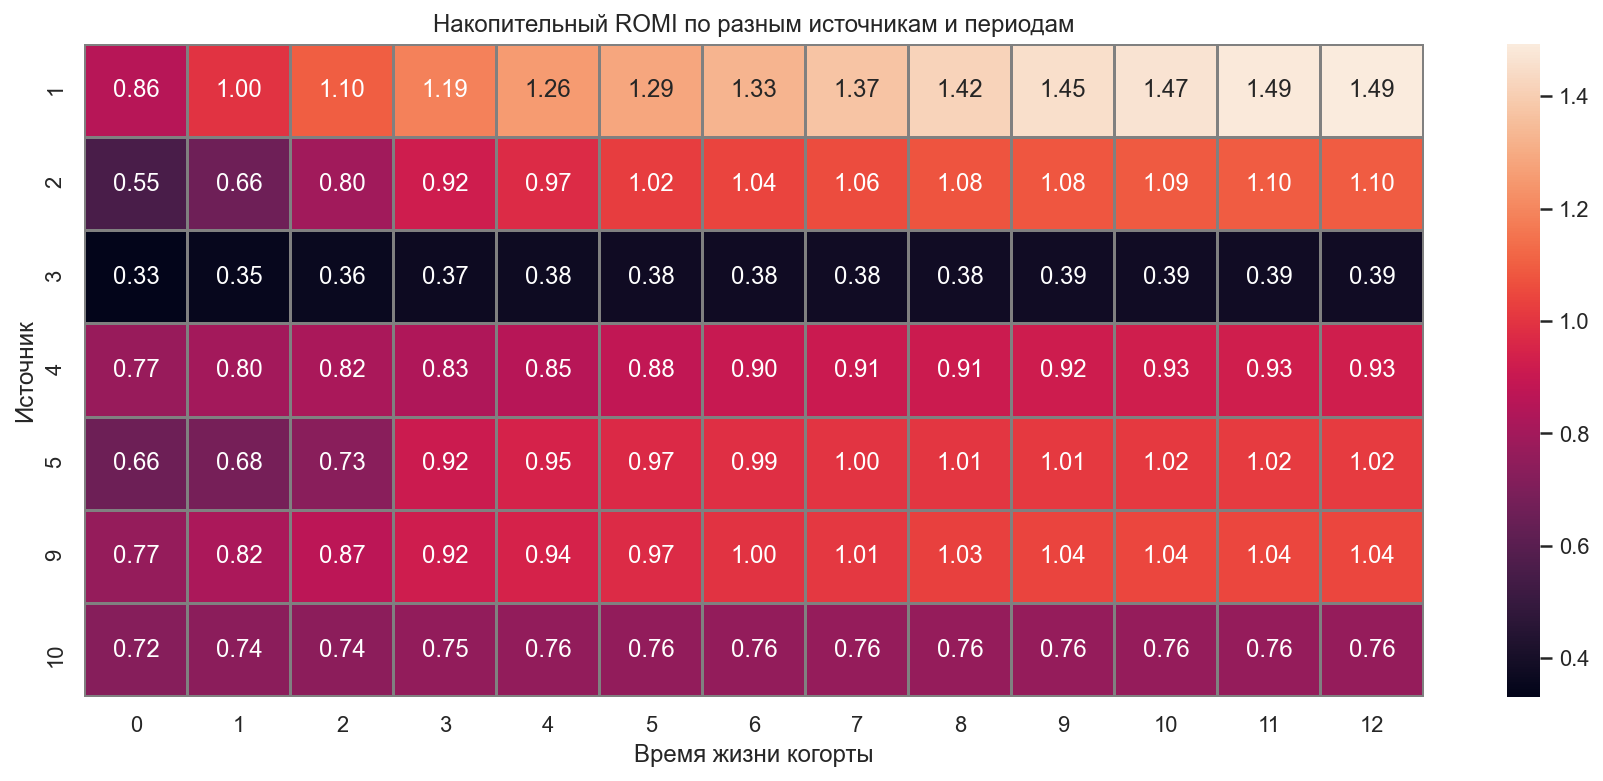

In [222]:
plt.figure(figsize=(15, 6));
plt.title('Накопительный ROMI по разным источникам и периодам');
sns.heatmap(romi_table, annot=True, fmt='.2f', linewidths=1, linecolor='gray');
plt.xlabel('Время жизни когорты');
plt.ylabel('Источник');

Как показал анализ, на конец выборки окупились источники 1, 2, 5 и 9. Причем лидером является источник 1, он же окупился уже после 1 периода. Расходным источником с ROMI = 0.4 остался номер 3. Причем источник 4, несмотря на то, что не вышел на показатель 1, показывает устойчивый рост со временем. Источник 10 имеет ROMI = 0.7, но никак не изменялся по времени, что может быть связано с тем, что бюджета на этот источник практически не было.

### Вывод раздела 2

В этом разделе были проведены расчеты различных метрик с построены графики для визуализации.

#### 1. Подготовили отчет по продукту
*   Выявлены отличия в пользователях с настольных систем и смартфонов. Пользователей с настольных систем практически в 3 раза больше пользователей со смартфонам, как в день, так и в неделю и месяц (600 против 221 в день).
*   В среднем каждый пользователь заходил на сайт чуть более одного раза, по количеству сессий в день также лидируют визиты с настольных систем (656 против 233).
*   Сессии по медиане длятся около 6 минут для настольных систем и 3 минуты для смартфонов.
*   На сайт возвращает оцень малая часть посетителей в следующие периоды (до 7%). Пользователи настольных систем возвращаются на 2 процентных пункты чаще, чем пользователи смартфонов?

#### 2. Рассчитали метрики продаж
*   Проведен расчет времени первой покупки после визита пользователей по платформам и источникам. В 90% случаев пользователи делали заказ сразу, в остальных случаях заказ с мобильных устройств происходит быстрее, чем с настольных систем, можно выделить источники 6 и 7 как неэффективные.
*   В отчете выделены когорты по времени первой покупки с июня 2017 года по июнь 2018 года.
*   В среднем клиенты совершают порядка 4201 заказа в месяц, но показатель количества заказов на одного покупателя постоянно снижается. На конец выборки этот показатель около единицы, а значит количество заказов практически равно количеству новых покупателей.
*   Средний чек для всех когорт в области 4-5, но в некоторые периоды для когорт сентября и декабря 2017 года средний чек вырастал вплоть до 53.2, что возможно, показывате сезонность бизнеса компании.
*   Наибольшую валовую прибыль принесли когорты сентября 2017 года и июня 2017 года (13.4 и 11.9 соответственно), LTV для более поздних когорт падает с течением времени.

#### 3. Провели анализ затрат на маркетинг
*   Всего было потрачено 329131.62 на продвижение продукта, больше всего (43%) на источник тип 3. Расходы выросли в сентябре 2017 года и достигли пика в декабре 2017 года, далее затраты снижались.
*   В среднем на привлечение одного клиента уходит около 10, пик стоимости привлечения пришелся на август 2018 года (10.8), далее затраты снижались с небольшим пиком в декабре 2017 года.
*   По расчета показателя ROMI затраты на маркетинг окупились только 4 из 10 каналов привлечения, причем наибольшую скорость показал канал 1.

## 3. Общий вывод и рекомендации

По результатам анализа на текущий момент затраты на маркетинг не окупаются. В то же время, благодаря запуску типа источника покупателей 3 в августе 2017 года количество покупателей выросло практически в 3 раза, что сразу дало показатель окупаемости свыше 1 в сентябре. В то же время, дальнейшие затраты на этот источник трафика не принес результата в связи с довольно низким средним чеком, что не дает окупиться затратам на привлечение клиентов. Было бы логично испробовать другие источники трафика и увеличить их финансирование за счет источника 3.

Так как больше всего пользователей приходят с настольных систем и только малая часть со смартфонов, стоит дополнительно рассмотреть маркетинговые акции и способы привлечения, нацеленные на пользователей смартфонов, так как, возможно, еще не исчерпан предел пользователем, которым был бы интересен сервис с мобильных устройств. В то же время, среднее время сессии на мобильных устройствах ниже и количество визитов также ниже, чем для настольных систем.

С учетом показателей метрики LTV валовой прибыли с клиента и низкой доли возвращающихся клиентов стоит рассмотреть дополнительные маркетинговый акции, направленные на удержание клиента (например, бонусная программа). Как показывает анализ затраты на привлечение пользовательских когорт могут окупаться спустя несколько месяцев, поэтому очень важно привлекать клиентов, которые уже попробовали продукт.

Как показал анализ, на конец выборки окупились источники 1, 2, 5 и 9. С точки зрения использования маркетингового бюджета стоит сохранить канал привлечения 1, но сократить расходы на каналы 3 и 4, так как их привлечение не окупается, а больше всего средств расходуется на канал 3. 4 канал в долгосрочной перспективе смог бы окупится, но он требует слишком большого бюджета, а ROMI растет слишком медленно. Каналы 6, 7, 8 практически не принесли новых заказов, но и бюджет на них был минимален. Стоит внимательнее отнестись к этим источникам, так как они могут как являться точкой потенциального роста, так и просто привлекать не ту аудиторию и развивать их не имеет смысла. Источник 10 показал стабильный результат, но за счет того, что бюджет на него не изменялся, возможно не смог раскрыть весь свой потенциал.